In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R

library("variancePartition")
library("edgeR")
library("BiocParallel")

Loading required package: ggplot2
Loading required package: limma
Loading required package: BiocParallel

Attaching package: ‘variancePartition’

The following object is masked from ‘package:limma’:

    topTable



# Identify outliers

In [3]:
adata_pb = sc.read('./pb_adata_MOL_sep.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 576 × 27766
    obs: 'sample', 'sample_lesion', 'diagnosis', 'sample_source', 'cell_type', 'sample_rep', 'replicate_cat', 'stim', 'sex', 'seq_pool', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'batch', 'lib_size', 'log_lib_size'
    uns: 'age_cat_colors', 'cell_type_colors', 'diagnosis_colors', 'log1p', 'pca', 'pmi_cat2_colors', 'pmi_cat_colors', 'sample_source_colors', 'seq_pool_colors', 'sex_colors', 'stim_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [4]:
adata_pb.obs['cell_stim'] = adata_pb.obs['cell_type'].astype(str) + '_' + adata_pb.obs['stim'].astype(str)

In [5]:
# Extract the log_lib_size column
log_lib_size = adata_pb.obs['log_lib_size']

# Compute the median
median = np.median(log_lib_size)

# Compute the MAD (Median Absolute Deviation)
mad = np.median(np.abs(log_lib_size - median))

# Define the upper and lower thresholds
upper_threshold = median + 3 * mad
lower_threshold = median - 3 * mad

# Find outliersGrant
outliers = adata_pb.obs[(log_lib_size < lower_threshold)]

# Print the results
print(f"Median: {median}, MAD: {mad}")
print(f"Lower threshold: {lower_threshold}")
print(f"Outliers:\n{outliers}")

Median: 13.525242514151744, MAD: 1.1232797359766673
Lower threshold: 10.155403306221743
Outliers:
                                              sample        sample_lesion  \
donor_Ind127-Sample2_0-1-0-0-0-0-0-0  Ind127-Sample2   Ind127-Sample2_CAL   
donor_Ind130-Sample4_0-1-0-0-0-0-0-0  Ind130-Sample4  Ind130-Sample4_NAWM   
donor_Ind122-Sample1_0-1-0-0-0        Ind122-Sample1    Ind122-Sample1_AL   
donor_Ind127-Sample2_0-1-0-0-0        Ind127-Sample2   Ind127-Sample2_CAL   
donor_Ind147-Sample1_0-1-0-0-0        Ind147-Sample1    Ind147-Sample1_RL   
donor_Ind102-Sample1_0-1-0-0          Ind102-Sample1    Ind102-Sample1_AL   
donor_Ind114-Sample1_0-1-0-0          Ind114-Sample1    Ind114-Sample1_AL   
donor_Ind127-Sample1_0-1-0-0          Ind127-Sample1    Ind127-Sample1_AL   
donor_Ind137-Sample1_0-1-0-0          Ind137-Sample1   Ind137-Sample1_CAL   
donor_Ind120-Sample1_0-1              Ind120-Sample1   Ind120-Sample1_CAL   
donor_Ind147-Sample1_0-1              Ind147-Sample1   

In [6]:
# Compute the max and min log_lib_size
max_log_lib_size = log_lib_size.max()
min_log_lib_size = log_lib_size.min()

print(f"Maximum log_lib_size: {max_log_lib_size}")
print(f"Minimum log_lib_size: {min_log_lib_size}")

Maximum log_lib_size: 17.05357717593746
Minimum log_lib_size: 9.473857817428666


In [7]:
print(f"All samples: {adata_pb.shape[0]}")

All samples: 576


In [8]:
# Extract the data as a pandas DataFrame
df = adata_pb.obs[['cell_type', 'stim']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'stim']).size().unstack(fill_value=0)
summary_table

stim,AL,CAL,CIL,NAWM,RL,WM
cell_type,,,,,,
COPs,1,0,2,1,1,0
MOL_A,19,16,12,17,11,13
MOL_B,20,16,13,17,11,13
MOL_C,21,16,13,17,11,13
MOL_D,18,14,10,14,11,10
MOL_E,9,7,4,9,6,5
MOL_F,3,3,3,3,2,1
MOL_G,19,15,12,16,10,8
OPCs,21,17,12,17,10,13


In [9]:
# Define the list of samples to remove
samples_to_remove = [
    "donor_Ind127-Sample2_0-1-0-0-0-0-0-0",
    "donor_Ind130-Sample4_0-1-0-0-0-0-0-0", 
    "donor_Ind122-Sample1_0-1-0-0-0", 
    "donor_Ind127-Sample2_0-1-0-0-0", 
    "donor_Ind147-Sample1_0-1-0-0-0",
    "donor_Ind102-Sample1_0-1-0-0",
    "donor_Ind114-Sample1_0-1-0-0",
    "donor_Ind127-Sample1_0-1-0-0",
    "donor_Ind137-Sample1_0-1-0-0",
    "donor_Ind120-Sample1_0-1",
    "donor_Ind147-Sample1_0-1"
]

# Filter out the samples to remove
adata_pb = adata_pb[~adata_pb.obs.index.isin(samples_to_remove)].copy()

# Confirm removal
print(f"Remaining samples: {adata_pb.shape[0]}")

Remaining samples: 565


In [10]:
# Extract the data as a pandas DataFrame
df = adata_pb.obs[['cell_type', 'stim']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'stim']).size().unstack(fill_value=0)
summary_table

stim,AL,CAL,CIL,NAWM,RL,WM
cell_type,,,,,,
COPs,1,0,2,1,1,0
MOL_A,19,15,12,16,11,13
MOL_B,20,16,13,17,11,13
MOL_C,21,16,13,17,11,13
MOL_D,17,13,10,14,10,10
MOL_E,6,6,4,9,6,5
MOL_F,3,3,3,3,2,1
MOL_G,19,14,12,16,9,8
OPCs,21,17,12,17,10,13


# Subset to relevant comparison 

In [11]:
# Extract the data as a pandas DataFrame
df = adata_pb.obs[['cell_type', 'stim']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'stim']).size().unstack(fill_value=0)
summary_table

stim,AL,CAL,CIL,NAWM,RL,WM
cell_type,,,,,,
COPs,1,0,2,1,1,0
MOL_A,19,15,12,16,11,13
MOL_B,20,16,13,17,11,13
MOL_C,21,16,13,17,11,13
MOL_D,17,13,10,14,10,10
MOL_E,6,6,4,9,6,5
MOL_F,3,3,3,3,2,1
MOL_G,19,14,12,16,9,8
OPCs,21,17,12,17,10,13


In [12]:
adata_sub= adata_pb[np.in1d(adata_pb.obs['cell_type'], 
                           ['MOL_G', 'MOL_C'])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (169, 27766)


In [13]:
adata_sub.obs[:5]

,sample,sample_lesion,diagnosis,sample_source,cell_type,sample_rep,replicate_cat,stim,sex,seq_pool,age_scale,age_cat,pmi_cat,pmi_cat2,batch,lib_size,log_lib_size,cell_stim
donor_Ind86-Sample2_0-1-0-0-0-0,Ind86-Sample2,Ind86-Sample2_WM,CTR,Edinburgh BB,MOL_C,WM_2,2,WM,M,Pool 2,0.782451,over_70,over_12H,over_12H,0,228293,12.338385,MOL_C_WM
donor_Ind98-Sample2_0-1-0-0-0-0,Ind98-Sample2,Ind98-Sample2_WM,CTR,Edinburgh BB,MOL_C,WM_1,1,WM,M,Pool 6,-1.759706,under_50,over_12H,over_12H,0,1320055,14.093184,MOL_C_WM
donor_Ind101-Sample1_0-1-0-0-0-0,Ind101-Sample1,Ind101-Sample1_CIL,SPMS,UK MS TB,MOL_C,CIL_1,1,CIL,F,Pool 5,0.645037,inbetween,over_12H,over_12H,0,242916,12.400471,MOL_C_CIL
donor_Ind101-Sample2_0-1-0-0-0-0,Ind101-Sample2,Ind101-Sample2_CIL,SPMS,UK MS TB,MOL_C,CIL_2,2,CIL,F,Pool 3,0.645037,inbetween,over_12H,over_12H,0,216898,12.287182,MOL_C_CIL
donor_Ind101-Sample3_0-1-0-0-0-0,Ind101-Sample3,Ind101-Sample3_RL,SPMS,UK MS TB,MOL_C,RL_1,1,RL,F,Pool 1,0.645037,inbetween,over_12H,over_12H,0,1664982,14.325325,MOL_C_RL


In [14]:
# Unique values in the 'condition' column
unique_conditions = adata_sub.obs['stim'].unique()
for condition in unique_conditions:
    print(condition)

WM
CIL
RL
NAWM
AL
CAL


In [15]:
adata_sub= adata_sub[np.in1d(adata_sub.obs['stim'], 
                           ['WM',
                              'AL'
                           ])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (61, 27766)


In [16]:
# Check if the 'sample_rep' column exists
if 'sample_lesion' in adata_sub.obs.columns:
    # Set the 'sample_rep' column as the index
    adata_sub.obs.set_index('sample_lesion', inplace=True)
else:
    print("The column 'sample' does not exist in adata_sub.obs.")

adata_sub.obs.index.name = None

In [17]:
# Add the index back as a column called 'sample_lesion'
adata_sub.obs['sample_lesion'] = adata_sub.obs.index

In [18]:
adata_sub.obs['indiv_id'] = adata_sub.obs['sample'].str.split('-').str[0]
adata_sub.obs[:5]

,sample,diagnosis,sample_source,cell_type,sample_rep,replicate_cat,stim,sex,seq_pool,age_scale,age_cat,pmi_cat,pmi_cat2,batch,lib_size,log_lib_size,cell_stim,sample_lesion,indiv_id
Ind86-Sample2_WM,Ind86-Sample2,CTR,Edinburgh BB,MOL_C,WM_2,2,WM,M,Pool 2,0.782451,over_70,over_12H,over_12H,0,228293,12.338385,MOL_C_WM,Ind86-Sample2_WM,Ind86
Ind98-Sample2_WM,Ind98-Sample2,CTR,Edinburgh BB,MOL_C,WM_1,1,WM,M,Pool 6,-1.759706,under_50,over_12H,over_12H,0,1320055,14.093184,MOL_C_WM,Ind98-Sample2_WM,Ind98
Ind102-Sample1_AL,Ind102-Sample1,SPMS,Amsterdam BB,MOL_C,AL_1,1,AL,M,Pool 4,0.301502,inbetween,6H_to_12H,up_to_12H,0,800507,13.593001,MOL_C_AL,Ind102-Sample1_AL,Ind102
Ind103-Sample1_AL,Ind103-Sample1,RRMS,Amsterdam BB,MOL_C,AL_2,2,AL,F,Pool 3,-1.484878,under_50,up_to_6H,up_to_12H,0,871195,13.677621,MOL_C_AL,Ind103-Sample1_AL,Ind103
Ind106-Sample1_AL,Ind106-Sample1,SPMS,UK MS TB,MOL_C,AL_3,3,AL,M,Pool 2,0.164088,inbetween,over_12H,over_12H,0,157410,11.966609,MOL_C_AL,Ind106-Sample1_AL,Ind106


In [19]:
# Extract the data as a pandas DataFrame
df = adata_sub.obs[['cell_stim', 'stim']]

# Create a summary table
summary_table = df.groupby(['cell_stim', 'stim']).size().unstack(fill_value=0)
summary_table

stim,AL,WM
cell_stim,,
MOL_C_AL,21,0
MOL_C_WM,0,13
MOL_G_AL,19,0
MOL_G_WM,0,8


In [20]:
adata_sub= adata_sub[np.in1d(adata_sub.obs['cell_stim'], 
                           ['MOL_C_WM',
                              'MOL_G_AL'
                           ])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (32, 27766)


In [21]:
adata_sub

AnnData object with n_obs × n_vars = 32 × 27766
    obs: 'sample', 'diagnosis', 'sample_source', 'cell_type', 'sample_rep', 'replicate_cat', 'stim', 'sex', 'seq_pool', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'batch', 'lib_size', 'log_lib_size', 'cell_stim', 'sample_lesion', 'indiv_id'
    uns: 'age_cat_colors', 'cell_type_colors', 'diagnosis_colors', 'log1p', 'pca', 'pmi_cat2_colors', 'pmi_cat_colors', 'sample_source_colors', 'seq_pool_colors', 'sex_colors', 'stim_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

... storing 'diagnosis' as categorical
... storing 'sample_source' as categorical
... storing 'cell_type' as categorical
... storing 'replicate_cat' as categorical
... storing 'stim' as categorical
... storing 'sex' as categorical
... storing 'seq_pool' as categorical
... storing 'age_scale' as categorical
... storing 'age_cat' as categorical
... storing 'pmi_cat' as categorical
... storing 'pmi_cat2' as categorical
... storing 'batch' as categorical
... storing 'cell_stim' as categorical
... storing 'indiv_id' as categorical


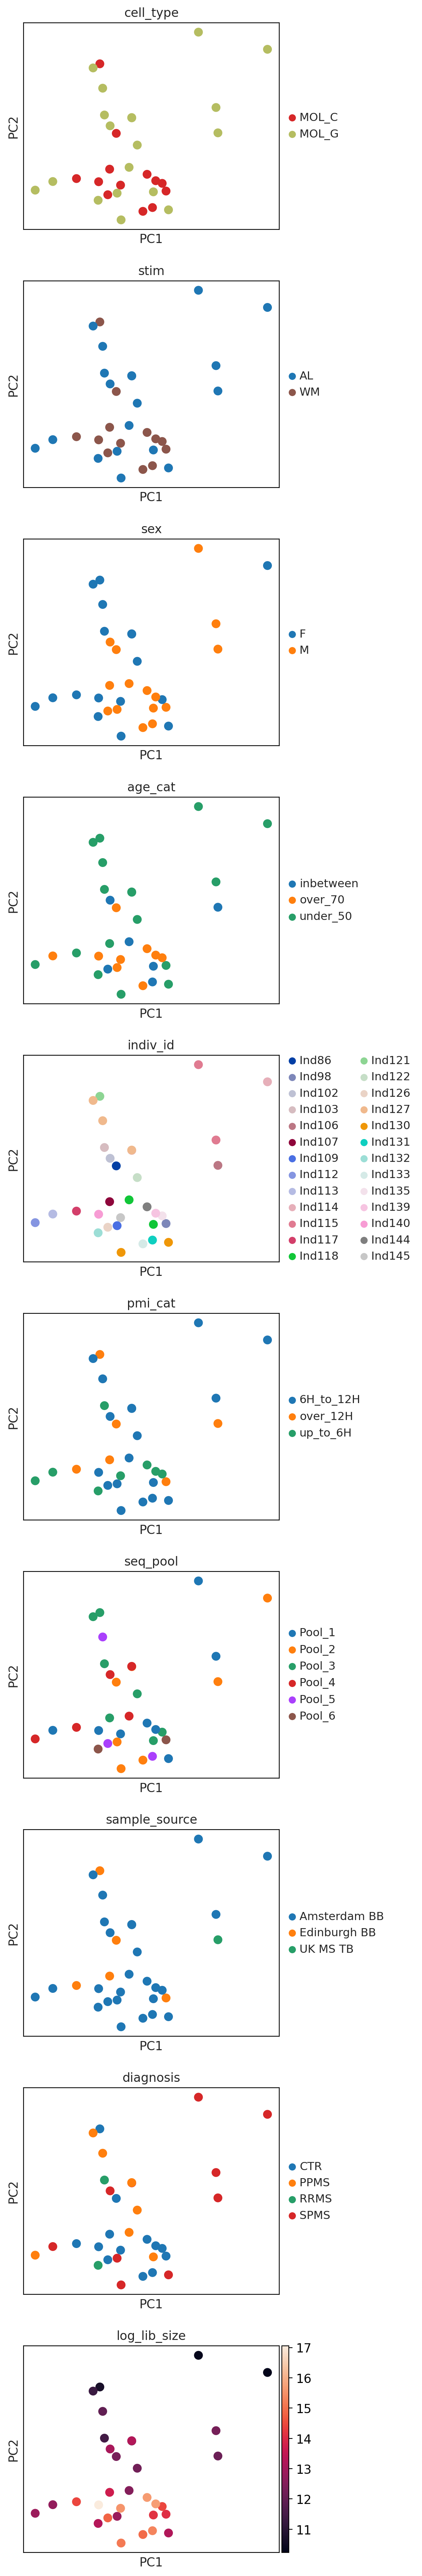

In [197]:
sc.pl.pca(adata_sub, color=["cell_type", "stim", "sex", "age_cat", "indiv_id",
                            "pmi_cat", "seq_pool", "sample_source", "diagnosis", "log_lib_size"], 
          ncols=1, size=300)

# Rename the MOL clusters for NEW letter based nomenclature

In [23]:
# Replace space with underscore in the 'seq_pool' column
adata_sub.obs['seq_pool'] = adata_sub.obs['seq_pool'].str.replace(' ', '_')
adata_sub.obs[:5]

,sample,diagnosis,sample_source,cell_type,sample_rep,replicate_cat,stim,sex,seq_pool,age_scale,age_cat,pmi_cat,pmi_cat2,batch,lib_size,log_lib_size,cell_stim,sample_lesion,indiv_id
Ind86-Sample2_WM,Ind86-Sample2,CTR,Edinburgh BB,MOL_C,WM_2,2,WM,M,Pool_2,0.782451,over_70,over_12H,over_12H,0,228293,12.338385,MOL_C_WM,Ind86-Sample2_WM,Ind86
Ind98-Sample2_WM,Ind98-Sample2,CTR,Edinburgh BB,MOL_C,WM_1,1,WM,M,Pool_6,-1.759706,under_50,over_12H,over_12H,0,1320055,14.093184,MOL_C_WM,Ind98-Sample2_WM,Ind98
Ind107-Sample1_WM,Ind107-Sample1,CTR,Edinburgh BB,MOL_C,WM_3,3,WM,M,Pool_3,-0.935223,under_50,over_12H,over_12H,0,891756,13.700948,MOL_C_WM,Ind107-Sample1_WM,Ind107
Ind117-Sample1_WM,Ind117-Sample1,CTR,Edinburgh BB,MOL_C,WM_4,4,WM,F,Pool_4,-0.935223,under_50,over_12H,over_12H,0,1868798,14.440806,MOL_C_WM,Ind117-Sample1_WM,Ind117
Ind121-Sample1_WM,Ind121-Sample1,CTR,Edinburgh BB,MOL_C,WM_5,5,WM,F,Pool_3,-0.729102,under_50,over_12H,over_12H,0,43506,10.680654,MOL_C_WM,Ind121-Sample1_WM,Ind121


In [24]:
#Check the counts data
print(adata_sub.X[:5, :5])

[[ 1  0  0  0 15]
 [11  1  0  0 37]
 [ 7  0  0  0 25]
 [13  0  0  0 55]
 [ 1  0  0  0  0]]


# Start R code: QC of log transformation

In [25]:
for col in adata_sub.obs.columns:
    if pd.api.types.is_categorical_dtype(adata_sub.obs[col]):
        adata_sub.obs[col] = adata_sub.obs[col].astype(str)

In [26]:
%%R -i adata_sub

# Concatenate label and cell type for group factor
group <- colData(adata_sub)$stim #ctrl or stim
replicate <- colData(adata_sub)$replicate_cat #replicate number
batch <- colData(adata_sub)$sample_lesion #this is each indiv sample

# Concatenate label and cell type for group factor
sex <- colData(adata_sub)$sex #ctrl or stim
age_cat <- colData(adata_sub)$age_cat #replicate number
pmi_cat <- colData(adata_sub)$pmi_cat #this is each indiv sample
pmi_cat2 <- colData(adata_sub)$pmi_cat2 #replicate number
seq_pool <- colData(adata_sub)$seq_pool #this is each indiv sample

treatments <- data.frame("Group"=group, "Reps"=replicate, "Batch"=batch,
                        "Sex"=sex, "Age_cat"=age_cat, "Pmi_cat"=pmi_cat, "Pmi_cat2"=pmi_cat2,
                        "Seq_pool"=seq_pool)
head(treatments)

                  Group Reps             Batch Sex   Age_cat   Pmi_cat
Ind86-Sample2_WM     WM    2  Ind86-Sample2_WM   M   over_70  over_12H
Ind98-Sample2_WM     WM    1  Ind98-Sample2_WM   M  under_50  over_12H
Ind107-Sample1_WM    WM    3 Ind107-Sample1_WM   M  under_50  over_12H
Ind117-Sample1_WM    WM    4 Ind117-Sample1_WM   F  under_50  over_12H
Ind121-Sample1_WM    WM    5 Ind121-Sample1_WM   F  under_50  over_12H
Ind126-Sample1_WM    WM    6 Ind126-Sample1_WM   M inbetween 6H_to_12H
                   Pmi_cat2 Seq_pool
Ind86-Sample2_WM   over_12H   Pool_2
Ind98-Sample2_WM   over_12H   Pool_6
Ind107-Sample1_WM  over_12H   Pool_3
Ind117-Sample1_WM  over_12H   Pool_4
Ind121-Sample1_WM  over_12H   Pool_3
Ind126-Sample1_WM up_to_12H   Pool_5


In [27]:
%%R -i adata_sub

# Create the treatments dataframe with samples as a column, not as row names
treatments <- data.frame(
  #Sample = colData(adata_sub)$sample,      # Sample column
  Group = colData(adata_sub)$stim,        # Group (e.g., ctrl or stim)
  Donor = colData(adata_sub)$indiv_id,    # Donor information
  Sex = colData(adata_sub)$sex,           # Sex information
  Age_cat = colData(adata_sub)$age_cat,   # Age category
  Pmi_cat = colData(adata_sub)$pmi_cat   # Post-mortem interval category
)

# Check the updated dataframe to confirm
head(treatments)

                  Group  Donor Sex   Age_cat   Pmi_cat
Ind86-Sample2_WM     WM  Ind86   M   over_70  over_12H
Ind98-Sample2_WM     WM  Ind98   M  under_50  over_12H
Ind107-Sample1_WM    WM Ind107   M  under_50  over_12H
Ind117-Sample1_WM    WM Ind117   F  under_50  over_12H
Ind121-Sample1_WM    WM Ind121   F  under_50  over_12H
Ind126-Sample1_WM    WM Ind126   M inbetween 6H_to_12H


In [28]:
%%R

#Create a DGElist object using the anndata counts in 'X'
x <- DGEList(assay(adata_sub, "X"), group=colData(adata_sub)$stim)

samplenames <- colnames(x$counts)

print("Dimensions before subsetting:")
print(dim(x))

# Check counts per group before filtering
print(table(x$samples$group))

[1] "Dimensions before subsetting:"
[1] 27766    32

AL WM 
19 13 


In [29]:
%%R

# Adjust for batch-- ie publication in the model matrix
design_full <- model.matrix(~0 + Group + Sex + Age_cat + Pmi_cat, data=treatments)
rownames(design_full) <- colnames(x)
colnames(design_full)

[1] "GroupAL"         "GroupWM"         "SexM"            "Age_catover_70" 
[5] "Age_catunder_50" "Pmi_catover_12H" "Pmi_catup_to_6H"


In [30]:
%%R

# More strict removal of genes, tried group, pub and batch
keep.expr <- filterByExpr(x, design_full)
x2 <- x[keep.expr,, keep.lib.sizes=FALSE]
dim(x2)

[1] 10487    32


In [31]:
%%R

# More strict removal of genes, tried group, pub and batch
keep.exprs <- filterByExpr(x, group=batch)
b <- x[keep.exprs,, keep.lib.sizes=FALSE]
dim(b)

[1] 12616    32


In [32]:
%%R
## Calc norm factors before to normalize library sizes, then cpm divides counts by lib sizes
#X is before trimming, Y is after trimming, X2 is also trimmed but differently
x2 <- calcNormFactors(x2, method = "TMM")
x2$samples$norm.factors

 [1] 0.9598366 1.0083422 0.9617107 0.9717790 1.1672738 0.9871956 0.9635721
 [8] 0.9776579 0.8280216 0.9376269 0.9798478 0.9059465 0.9493403 0.8887191
[15] 1.0946262 0.9682829 1.0642090 1.0121653 1.0528771 0.9016436 1.3525390
[22] 0.9160340 1.2248661 1.0059743 0.9523796 1.0559308 1.0329320 0.8132512
[29] 0.9178632 1.1320024 1.1548069 1.0443447


In [33]:
%%R
cd <- x2$samples$group
print(cd)

 [1] WM WM WM WM WM WM WM WM WM WM WM WM WM AL AL AL AL AL AL AL AL AL AL AL AL
[26] AL AL AL AL AL AL AL
Levels: AL WM


# Check effect of batch correction?

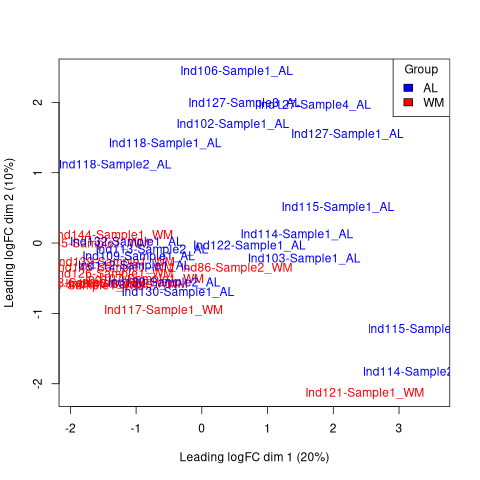

In [34]:
%%R
# Assuming 'group' is stored in y$samples dataframe
group <- x2$samples$group

# Generate a numeric vector from group factors (if not already factor, convert it)
group_factor <- as.factor(group)
group_colors <- as.numeric(group_factor)  # This converts factors to unique integers

# Define a set of colors corresponding to the factors
# Example: If you have two groups, you could define two colors
colors <- c("blue", "red")  # Adjust the number and colors based on your actual groups

# Use these colors in your plotMDS
plotMDS(x2, col = colors[group_colors])

# Adding a legend for clarity
legend("topright", legend=levels(group_factor), fill=colors, title="Group")

In [ ]:
%%R
# Convert to CPM and log2 transformation. 
logCPM <- edgeR::cpm(x2, log=TRUE, prior.count=3)
heatmap(logCPM)

In [ ]:
%%R
#Batch is set to the publication of origin to remove effects between sample origins
logCPM_no_batch <- removeBatchEffect(logCPM, batch=pmi_cat) 
heatmap(logCPM_no_batch)

In [ ]:
%%R

#Batch is set to the publication of origin to remove effects between sample origins
logCPM_no_batch_sex <- removeBatchEffect(logCPM, batch=sex) 
heatmap(logCPM_no_batch_sex)

In [ ]:
%%R

#Batch is set to the publication of origin to remove effects between sample origins
logCPM_no_batch_age <- removeBatchEffect(logCPM, batch=age_cat) 
heatmap(logCPM_no_batch_age)

In [ ]:
%%R

#Batch is set to the publication of origin to remove effects between sample origins
logCPM_no_batch_pool <- removeBatchEffect(logCPM, batch=seq_pool) 
heatmap(logCPM_no_batch_pool)

In [ ]:
%%R

# Convert categorical variables to factors
treatments$Batch <- as.factor(treatments$Batch)
treatments$Sex <- as.factor(treatments$Sex)
treatments$Age_cat <- as.factor(treatments$Age_cat)
treatments$Pmi_cat <- as.factor(treatments$Pmi_cat)
treatments$Seq_pool <- as.factor(treatments$Seq_pool)
treatments$Group <- as.factor(treatments$Group)

In [ ]:
%%R

# Correct for multiple batch effects
logCPM_no_batch <- removeBatchEffect(
  logCPM, 
  batch = treatments$Age_cat,   # Primary batch effect
  batch2 = treatments$Seq_pool,   # Secondary batch effect
  covariates = model.matrix(~ treatments$Pmi_cat + treatments$Sex)[, -1] # Other covariates
)

# Plot the corrected heatmap
heatmap(logCPM_no_batch)

In [ ]:
%%R

# Correct for multiple batch effects
logCPM_no_batch <- removeBatchEffect(
  logCPM, 
  batch = treatments$Seq_pool,   # Primary batch effect
  batch2 = treatments$Age_cat,   # Secondary batch effect
  covariates = model.matrix(~ treatments$Sex + treatments$Pmi_cat)[, -1] # Other covariates
)

# Plot the corrected heatmap
heatmap(logCPM_no_batch)

In [ ]:
%%R

donor <- colData(adata_sub)$indiv_id #this is each indiv sample

#Batch is set to the publication of origin to remove effects between sample origins
logCPM_no_batch <- removeBatchEffect(logCPM, batch=donor) 

In [ ]:
%%R

heatmap(logCPM_no_batch)

# Voom with quality weights- sex, age, pmi, seq_pool

In [35]:
%%R
head(treatments)

                  Group  Donor Sex   Age_cat   Pmi_cat
Ind86-Sample2_WM     WM  Ind86   M   over_70  over_12H
Ind98-Sample2_WM     WM  Ind98   M  under_50  over_12H
Ind107-Sample1_WM    WM Ind107   M  under_50  over_12H
Ind117-Sample1_WM    WM Ind117   F  under_50  over_12H
Ind121-Sample1_WM    WM Ind121   F  under_50  over_12H
Ind126-Sample1_WM    WM Ind126   M inbetween 6H_to_12H


In [36]:
%%R
donor <- colData(adata_sub)$indiv_id #this is each indiv sample
donor

 Ind86-Sample2_WM  Ind98-Sample2_WM Ind107-Sample1_WM Ind117-Sample1_WM 
          "Ind86"           "Ind98"          "Ind107"          "Ind117" 
Ind121-Sample1_WM Ind126-Sample1_WM Ind131-Sample1_WM Ind133-Sample1_WM 
         "Ind121"          "Ind126"          "Ind131"          "Ind133" 
Ind135-Sample1_WM Ind139-Sample1_WM Ind140-Sample1_WM Ind144-Sample1_WM 
         "Ind135"          "Ind139"          "Ind140"          "Ind144" 
Ind145-Sample1_WM Ind102-Sample1_AL Ind103-Sample1_AL Ind106-Sample1_AL 
         "Ind145"          "Ind102"          "Ind103"          "Ind106" 
Ind109-Sample1_AL Ind112-Sample1_AL Ind113-Sample2_AL Ind114-Sample1_AL 
         "Ind109"          "Ind112"          "Ind113"          "Ind114" 
Ind114-Sample2_AL Ind115-Sample1_AL Ind115-Sample2_AL Ind118-Sample1_AL 
         "Ind114"          "Ind115"          "Ind115"          "Ind118" 
Ind118-Sample2_AL Ind122-Sample1_AL Ind127-Sample1_AL Ind127-Sample3_AL 
         "Ind118"          "Ind122"          "Ind12

In [37]:
%%R
head(design_full)

                  GroupAL GroupWM SexM Age_catover_70 Age_catunder_50
Ind86-Sample2_WM        0       1    1              1               0
Ind98-Sample2_WM        0       1    1              0               1
Ind107-Sample1_WM       0       1    1              0               1
Ind117-Sample1_WM       0       1    0              0               1
Ind121-Sample1_WM       0       1    0              0               1
Ind126-Sample1_WM       0       1    1              0               0
                  Pmi_catover_12H Pmi_catup_to_6H
Ind86-Sample2_WM                1               0
Ind98-Sample2_WM                1               0
Ind107-Sample1_WM               1               0
Ind117-Sample1_WM               1               0
Ind121-Sample1_WM               1               0
Ind126-Sample1_WM               0               0


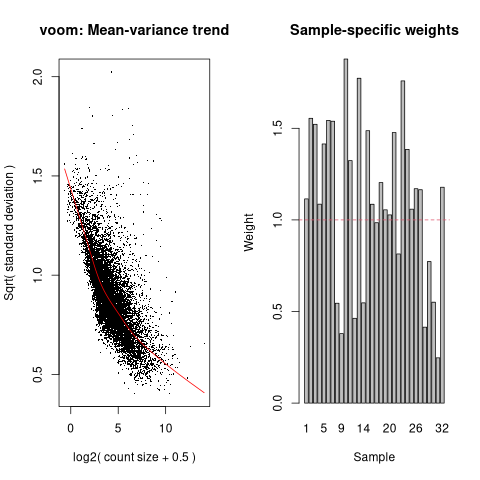

In [38]:
%%R

y_vqw_full <- voomWithQualityWeights(x2$counts, design_full, plot=TRUE)

In [39]:
%%R

corfit <- duplicateCorrelation(y_vqw_full, design_full, block=donor)
corfit$consensus.correlation

[1] 0.4369703


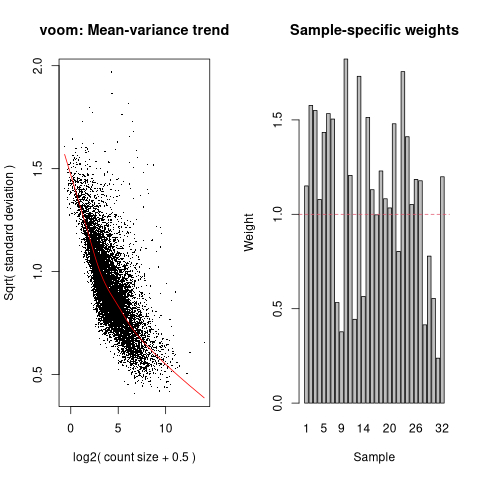

In [40]:
%%R

y2 <- voomWithQualityWeights(x2$counts, design_full, plot=TRUE, block=donor, correlation=corfit$consensus)

In [41]:
%%R

corfit2 <- duplicateCorrelation(y2, design_full, block=donor)
corfit2$consensus.correlation

[1] 0.4372079


In [42]:
%%R

fit <- lmFit(y2, design_full, block=donor, correlation=corfit2$consensus)

In [43]:
%%R

contr <- makeContrasts(GroupAL - GroupWM, levels = colnames(coef(fit)))

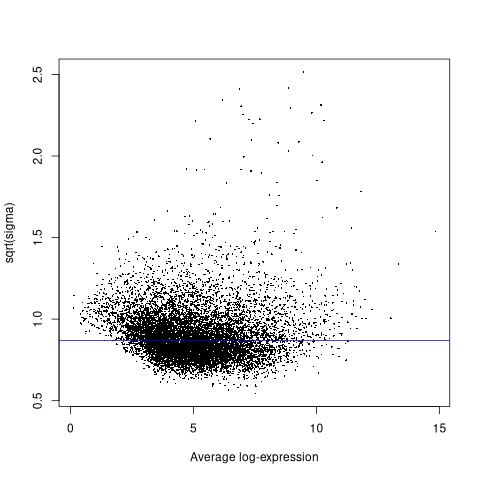

In [44]:
%%R

tmp <- contrasts.fit(fit, contr)
tmp2 <- eBayes(tmp)
tt_full <- topTable(tmp2, sort.by = "P", n = Inf)

plotSA(tmp2, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [45]:
%%R

# Retrieve the top results without sorting by p-value directly
tt <- topTable(tmp2, sort.by = "P", n = Inf)
head(tt, 10)

               logFC   AveExpr         t      P.Value    adj.P.Val        B
ANK3       -1.592753 10.551017 -14.36109 1.387716e-15 1.015878e-11 25.40749
PLPPR1     -2.080521  7.336685 -14.19114 1.937405e-15 1.015878e-11 25.18238
OPALIN     -4.213407  6.701409 -13.70292 5.136909e-15 1.795692e-11 24.01753
FCHSD2     -1.625124  8.619550 -13.08688 1.822714e-14 3.959859e-11 22.95623
INPP5F      3.177969  6.433038  13.07004 1.887984e-14 3.959859e-11 22.85857
SIPA1L1    -2.014195  7.597691 -12.72671 3.896559e-14 6.810536e-11 22.24009
LINC00639  -1.643793  8.282305 -11.69611 3.721649e-13 5.575562e-10 19.97241
PPP2R2B    -2.056765 11.371243 -11.59367 4.689826e-13 6.147776e-10 19.48557
AL392023.2 -2.565616  5.515443 -10.99483 1.859633e-12 2.166886e-09 18.29861
EFR3B       2.148840  6.358264  10.94884 2.070988e-12 2.171845e-09 18.31806


In [46]:
%%R
length(which(tt$adj.P.Val < 0.05))

[1] 2759


In [47]:
%%R

# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt[tt$adj.P.Val < 0.05 & tt$logFC > 1, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 818
         logFC  AveExpr        t      P.Value    adj.P.Val         B
GFAP  7.564068 2.382474 7.505539 1.421920e-08 1.511346e-06  9.198889
GBP2  7.218389 2.562658 9.786617 3.441301e-11 2.122878e-08 13.942403
EGR1  7.012268 2.613755 6.807723 1.016009e-07 6.418605e-06  6.966164
FOS   6.181031 3.058251 4.439816 9.856485e-05 1.175938e-03  1.305437
ANXA2 6.086154 2.113727 8.625928 6.791985e-10 1.582834e-07 11.453417
HSPA6 5.991950 1.670244 6.441829 2.901525e-07 1.364497e-05  6.330036


In [48]:
%%R
genes_up_sorted

                 logFC    AveExpr         t      P.Value    adj.P.Val
GFAP          7.564068  2.3824742  7.505539 1.421920e-08 1.511346e-06
GBP2          7.218389  2.5626576  9.786617 3.441301e-11 2.122878e-08
EGR1          7.012268  2.6137547  6.807723 1.016009e-07 6.418605e-06
FOS           6.181031  3.0582515  4.439816 9.856485e-05 1.175938e-03
ANXA2         6.086154  2.1137267  8.625928 6.791985e-10 1.582834e-07
HSPA6         5.991950  1.6702437  6.441829 2.901525e-07 1.364497e-05
HSPB1         5.955828  2.7037757  4.886687 2.697788e-05 4.178981e-04
EMP1          5.827370  1.4731777  6.270007 4.766257e-07 1.960146e-05
SERPINE1      5.608913  1.1756292  6.186595 6.069132e-07 2.392744e-05
FAM107A       5.576281  0.9865284  6.277536 4.663531e-07 1.933055e-05
VGF           5.035674  0.4545137  5.923465 1.304117e-06 4.226674e-05
VIM           5.028588  0.6953553  5.478709 4.780506e-06 1.157810e-04
LGALS1        5.006358  1.5787419  6.539826 2.188294e-07 1.114012e-05
IER5L         4.9392

ANKDD1B       2.284771  2.3542603  4.009017 3.368899e-04 3.115489e-03
CFAP61        2.282211  3.6094626  5.795321 1.894953e-06 5.597853e-05
MAP2          2.279974  3.0813680  4.465865 9.143731e-05 1.109842e-03
AC107081.2    2.279940  2.0966185  4.937345 2.327336e-05 3.703608e-04
ETV5          2.272407  5.4140870  5.060763 1.623239e-05 2.837151e-04
CAV2          2.267718  3.6668881  6.571587 1.997405e-07 1.063289e-05
DRAM1         2.264774  2.3010356  4.346207 1.290044e-04 1.464145e-03
AC090833.1    2.263558  0.8824432  3.153252 3.475563e-03 1.812443e-02
CHRNA4        2.256152  1.7327525  3.454965 1.559029e-03 9.878873e-03
C12orf75      2.255331  1.1477373  2.844372 7.657618e-03 3.308836e-02
AC133528.1    2.253607  1.2611612  3.122522 3.765343e-03 1.924145e-02
GULP1         2.252724  4.9051091  6.445407 2.871752e-07 1.356579e-05
MYRIP         2.247236  6.9221644  8.448535 1.088039e-09 2.037548e-07
THSD7B        2.244693  1.4364669  2.809198 8.359675e-03 3.543570e-02
BTN3A2        2.2411

IRF2BPL       1.490099  3.7687082  4.582741 6.523812e-05 8.509355e-04
ATAD3C        1.489024  4.6339272  3.903081 4.537826e-04 3.897476e-03
KIFC2         1.488475  1.8069443  2.716940 1.049760e-02 4.230845e-02
HSPA4         1.488374  6.4157496  6.714250 1.326955e-07 7.906693e-06
AC116362.1    1.485596  5.8966589  6.147326 6.801404e-07 2.565695e-05
CCDC117       1.485014  4.5224088  6.635211 1.664046e-07 9.282365e-06
ENPP6         1.482503  5.8124480  5.179747 1.146399e-05 2.230481e-04
ITPKB         1.476902  7.9905403  5.973981 1.125704e-06 3.795904e-05
AC100793.3    1.469843  3.0797763  4.500564 8.272806e-05 1.024285e-03
HEBP2         1.465352  2.7169915  3.619559 9.961170e-04 7.120845e-03
TMEM255A      1.462708  3.3063129  4.332585 1.341454e-04 1.502973e-03
SBF2-AS1      1.460609  3.6022532  5.204657 1.065851e-05 2.128980e-04
MTHFD2        1.459154  1.9035848  3.094728 4.047087e-03 2.030708e-02
LHFPL4        1.457513  1.9432039  2.874392 7.102572e-03 3.137518e-02
PPM1F         1.4567

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [49]:
%%R

# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt[tt$adj.P.Val < 0.05 & tt$logFC < -1, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 383
              logFC  AveExpr          t      P.Value    adj.P.Val         B
KCNAB1    -4.249839 5.981777  -9.741693 3.849740e-11 2.242901e-08 15.392198
OPALIN    -4.213407 6.701409 -13.702916 5.136909e-15 1.795692e-11 24.017530
IFNG-AS1  -3.648270 3.563133 -10.449428 6.782210e-12 6.444695e-09 16.339661
PLCL2     -3.523783 3.876999  -7.069956 4.824485e-08 3.693020e-06  8.497951
LINC02073 -3.501713 4.567870  -8.858430 3.684909e-10 1.032253e-07 13.105812
GRIK2     -3.460261 3.934116  -6.006232 1.024850e-06 3.547063e-05  5.588874


## Retry with voom by group

Group:
1 AL 
2 WM 


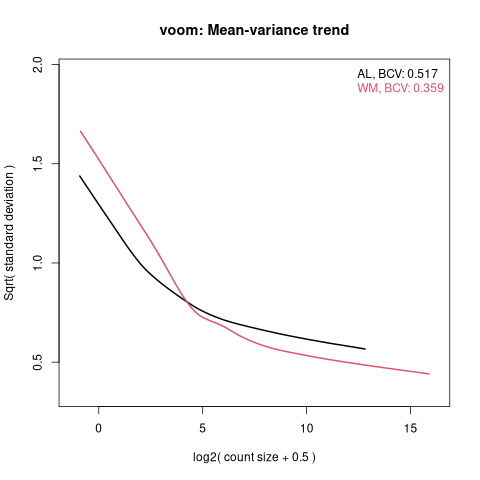

In [50]:
%%R
source("/afs/crc.nd.edu/user/e/eaboelno/sysVI_analysis/MM_sysVI/voomByGroup.R")
y_vbg <- voomByGroup(x2,design = design_full, group = cd, plot = "combine")

In [51]:
%%R
fit <- lmFit(y_vbg, design_full)

In [52]:
%%R
contr <- makeContrasts(GroupAL - GroupWM, levels = colnames(coef(fit)))

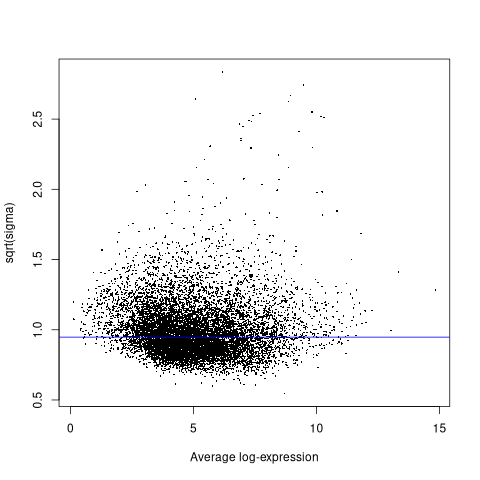

In [53]:
%%R
tmp <- contrasts.fit(fit, contr)
tmp2 <- eBayes(tmp)
tt_full <- topTable(tmp2, sort.by = "P", n = Inf)

plotSA(tmp2, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [54]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt_full[tt_full$adj.P.Val < 0.05 & tt_full$logFC > 1, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 715
           logFC   AveExpr        t      P.Value    adj.P.Val         B
GFAP    6.461024 2.3824750 4.950545 2.473135e-05 7.126555e-04 2.2453445
EGR1    6.264874 2.6137555 4.450563 1.029507e-04 1.962989e-03 1.0593939
GBP2    5.847222 2.5626584 6.155572 7.878996e-07 6.053163e-05 5.0026871
ANXA2   5.601505 2.1137275 5.871008 1.770327e-06 1.063664e-04 4.0970195
FAM107A 5.434039 0.9865292 5.717154 2.747287e-06 1.485093e-04 3.4850830
EMP1    5.413442 1.4731785 4.593910 6.850937e-05 1.470405e-03 0.9064059


In [55]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt_full[tt_full$adj.P.Val < 0.05 & tt_full$logFC < -1, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 329
              logFC  AveExpr          t      P.Value    adj.P.Val          B
KCNAB1    -4.240662 5.981777 -10.748001 5.549044e-12 8.313261e-09 17.2432549
OPALIN    -4.057541 6.701410 -13.748625 9.758284e-15 1.023351e-10 23.3743034
IFNG-AS1  -3.751887 3.563134 -10.096280 2.540492e-11 2.960238e-08 14.7804729
PLCL2     -3.675830 3.876999  -7.260606 3.610801e-08 7.424797e-06  8.7785815
LINC02073 -3.402687 4.567870  -8.204308 2.877759e-09 1.312133e-06 11.1709294
ATP8A2    -3.201978 4.591422  -4.340730 1.404817e-04 2.435094e-03  0.8490845


## Save output- make sure to rename!

In [111]:
%%R

# Add row names as a new column
tt$gene <- rownames(tt)

# Optionally reorder or select columns
tt <- tt[, c("gene", names(tt)[1:6])]

# Write to CSV file
write.table(tt, file = "./files/MOL_GvC_WM_v_AL_vwqw_blocked.csv", row.names = FALSE, sep = ",", quote = FALSE)

In [133]:
%%R

head(tt)

           gene     logFC   AveExpr         t      P.Value    adj.P.Val
ANK3       ANK3 -1.592753 10.551017 -14.36109 1.387716e-15 1.015878e-11
PLPPR1   PLPPR1 -2.080521  7.336685 -14.19114 1.937405e-15 1.015878e-11
OPALIN   OPALIN -4.213407  6.701409 -13.70292 5.136909e-15 1.795692e-11
FCHSD2   FCHSD2 -1.625124  8.619550 -13.08688 1.822714e-14 3.959859e-11
INPP5F   INPP5F  3.177969  6.433038  13.07004 1.887984e-14 3.959859e-11
SIPA1L1 SIPA1L1 -2.014195  7.597691 -12.72671 3.896559e-14 6.810536e-11
               B
ANK3    25.40749
PLPPR1  25.18238
OPALIN  24.01753
FCHSD2  22.95623
INPP5F  22.85857
SIPA1L1 22.24009


# Dream analysis

In [63]:
%%R

options(ports=8889)

In [64]:
%%R

param <- SnowParam(4, "SOCK", progressbar = TRUE)

In [65]:
%%R
head(treatments)

                  Group  Donor Sex   Age_cat   Pmi_cat
Ind86-Sample2_WM     WM  Ind86   M   over_70  over_12H
Ind98-Sample2_WM     WM  Ind98   M  under_50  over_12H
Ind107-Sample1_WM    WM Ind107   M  under_50  over_12H
Ind117-Sample1_WM    WM Ind117   F  under_50  over_12H
Ind121-Sample1_WM    WM Ind121   F  under_50  over_12H
Ind126-Sample1_WM    WM Ind126   M inbetween 6H_to_12H


In [66]:
%%R

# Convert Group column to a factor
treatments$Group <- factor(treatments$Group)

# Check levels to confirm AL and WM exist
levels(treatments$Group)

[1] "AL" "WM"


In [67]:
%%R

form <- ~ Group + (1 | Donor)

In [68]:
%%R

vobjDream <- voomWithDreamWeights(x2, form, treatments, BPPARAM = param)

iteration: 1234


In [69]:
%%R

fitmm <- dream(vobjDream, form, treatments)
fitmm <- eBayes(fitmm)

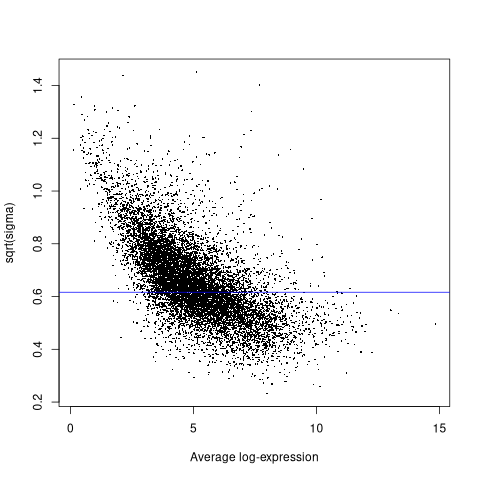

In [70]:
%%R

plotSA(fitmm, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [71]:
%%R

head(fitmm$design, 5)

                  (Intercept) GroupWM
Ind86-Sample2_WM            1       1
Ind98-Sample2_WM            1       1
Ind107-Sample1_WM           1       1
Ind117-Sample1_WM           1       1
Ind121-Sample1_WM           1       1


In [72]:
%%R

tt_dream <- topTable(fitmm, sort.by = "P", n = Inf)

Removing intercept from test coefficients


In [73]:
%%R
length(which(tt_dream$adj.P.Val < 0.05))

[1] 2109


In [144]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt_dream[tt_dream$adj.P.Val < 0.05 & tt_dream$logFC > 1, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 274
               gene    gene.1    logFC  AveExpr         t      P.Value
TMEM132B   TMEM132B  TMEM132B 4.204333 3.570902  6.995350 4.500053e-08
ATP8A2       ATP8A2    ATP8A2 3.931424 4.591422  6.089010 7.265067e-07
PLCL2         PLCL2     PLCL2 3.647650 3.876999  7.801878 5.460501e-09
OPALIN       OPALIN    OPALIN 3.605888 6.701410 12.501880 7.294486e-14
KCNAB1       KCNAB1    KCNAB1 3.377023 5.981777 10.714100 1.899705e-12
LINC01299 LINC01299 LINC01299 2.913095 3.593926  7.201779 3.691468e-08
             adj.P.Val         B
TMEM132B  6.839429e-06  7.056825
ATP8A2    5.405702e-05  5.861247
PLCL2     1.658317e-06  6.216093
OPALIN    3.824864e-10 13.909813
KCNAB1    5.260495e-09 18.037926
LINC01299 5.865520e-06  5.428372


In [78]:
%%R
head(genes_up_sorted, 20)

              logFC  AveExpr         t      P.Value    adj.P.Val          B
TMEM132B   4.204333 3.570902  6.995350 4.500053e-08 6.839429e-06  7.0568245
ATP8A2     3.931424 4.591422  6.089010 7.265067e-07 5.405702e-05  5.8612469
PLCL2      3.647650 3.876999  7.801878 5.460501e-09 1.658317e-06  6.2160925
OPALIN     3.605888 6.701410 12.501880 7.294486e-14 3.824864e-10 13.9098133
KCNAB1     3.377023 5.981777 10.714100 1.899705e-12 5.260495e-09 18.0379264
LINC01299  2.913095 3.593926  7.201779 3.691468e-08 5.865520e-06  5.4283721
LINC02073  2.794003 4.567870  7.934674 4.939131e-09 1.569596e-06  7.9301583
TMEM178B   2.749747 4.057778  5.339619 6.193903e-06 2.460434e-04  3.8268774
MMP17      2.720430 2.462376  5.791687 1.796590e-06 1.018424e-04  4.8227258
RASAL1     2.701496 5.278073  7.558768 3.084190e-08 5.216758e-06  7.1247552
GRIK2      2.642659 3.934117  4.406586 1.421567e-04 2.373881e-03 -0.8906976
ARPP21     2.637444 3.254208  3.448219 1.603009e-03 1.343785e-02 -1.5181085
AC012593.1 2

In [145]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt_dream[tt_dream$adj.P.Val < 0.05 & tt_dream$logFC < -1, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 598
             gene   gene.1     logFC  AveExpr         t      P.Value
GBP2         GBP2     GBP2 -6.123773 2.562658 -8.010834 1.288585e-08
EGR1         EGR1     EGR1 -5.367430 2.613755 -6.039521 1.031502e-06
ANXA2       ANXA2    ANXA2 -5.346736 2.113728 -7.432187 5.560261e-08
EMP1         EMP1     EMP1 -5.101796 1.473179 -7.168967 5.435671e-08
SERPINE1 SERPINE1 SERPINE1 -5.038207 1.175630 -6.639030 2.644556e-07
LGALS3     LGALS3   LGALS3 -4.836364 1.383500 -7.432317 1.213868e-07
            adj.P.Val        B
GBP2     2.880693e-06 4.909171
EGR1     6.718855e-05 4.278097
ANXA2    8.098675e-06 1.977122
EMP1     8.028716e-06 4.044970
SERPINE1 2.666679e-05 4.811449
LGALS3   1.533715e-05 6.061271


In [79]:
%%R

head(genes_down_sorted, 20)

             logFC   AveExpr         t      P.Value    adj.P.Val          B
GBP2     -6.123773 2.5626584 -8.010834 1.288585e-08 2.880693e-06  4.9091707
EGR1     -5.367430 2.6137555 -6.039521 1.031502e-06 6.718855e-05  4.2780970
ANXA2    -5.346736 2.1137275 -7.432187 5.560261e-08 8.098675e-06  1.9771223
EMP1     -5.101796 1.4731785 -7.168967 5.435671e-08 8.028716e-06  4.0449705
SERPINE1 -5.038207 1.1756300 -6.639030 2.644556e-07 2.666679e-05  4.8114491
LGALS3   -4.836364 1.3835002 -7.432317 1.213868e-07 1.533715e-05  6.0612707
GPRC5A   -4.776438 1.9506870 -8.189582 4.313247e-09 1.459130e-06  8.8901755
ARHGAP24 -4.622828 4.6395496 -6.544913 6.995042e-07 5.405702e-05  2.8097445
GFAP     -4.596972 2.3824750 -4.783564 4.657792e-05 1.058727e-03  0.9889628
OSMR-AS1 -4.501269 2.3135295 -6.390521 2.772691e-06 1.397943e-04  4.6911836
VGF      -4.494055 0.4545145 -5.847997 2.382254e-06 1.249135e-04  4.0785022
FOXP2    -4.372798 1.9191866 -5.842202 4.451531e-06 1.945134e-04  3.8736194
HLA-B    -4.

In [134]:
%%R
head(tt_dream)

           gene  gene.2  gene.1     logFC  AveExpr         t      P.Value
FCHSD2   FCHSD2  FCHSD2  FCHSD2  1.581572 8.619551  13.88307 1.396070e-15
OPALIN   OPALIN  OPALIN  OPALIN  3.605888 6.701410  12.50188 7.294486e-14
KCNAB1   KCNAB1  KCNAB1  KCNAB1  3.377023 5.981777  10.71410 1.899705e-12
INPP5F   INPP5F  INPP5F  INPP5F -2.975575 6.433039 -11.69498 2.258445e-12
ST8SIA5 ST8SIA5 ST8SIA5 ST8SIA5 -3.377412 5.242225 -10.60200 2.508103e-12
KCNH8     KCNH8   KCNH8   KCNH8  1.035896 9.884221  10.43234 3.830866e-12
           adj.P.Val         B
FCHSD2  1.464058e-11 25.108251
OPALIN  3.824864e-10 13.909813
KCNAB1  5.260495e-09 18.037926
INPP5F  5.260495e-09  9.405133
ST8SIA5 5.260495e-09 18.047799
KCNH8   6.695715e-09 17.637203


In [135]:
%%R

# Add row names as a new column
#tt_dream$gene <- rownames(tt_dream)

# Optionally reorder or select columns
tt_dream <- tt_dream[, c("gene", names(tt_dream)[1:8])]

# Write to CSV file
write.table(tt_dream, file = "./files/MOL_GvC_WM_v_AL_dream.csv", row.names = FALSE, sep = ",", quote = FALSE)

## Next try with additional variables

In [80]:
%%R
colnames(treatments)

[1] "Group"   "Donor"   "Sex"     "Age_cat" "Pmi_cat"


In [81]:
%%R

form <- ~ 0 + Group + Sex + Age_cat + Pmi_cat + (1 | Donor)

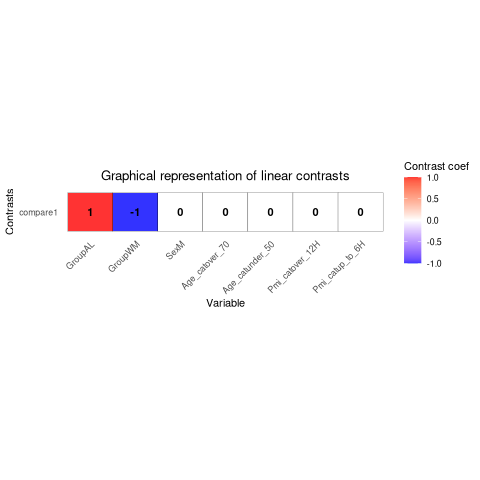

In [82]:
%%R

L <- makeContrastsDream(form, treatments,
  contrasts = c(
    compare1 = "GroupAL - GroupWM"
  )
)

# Visualize contrast matrix
plotContrasts(L)


In [83]:
%%R

vobjDream2 <- voomWithDreamWeights(x2, form, treatments, BPPARAM = param)

iteration: 1234


In [84]:
%%R

# fit dream model with contrasts
fit_full <- dream(vobjDream2, form, treatments, L)
fit_full <- eBayes(fit_full)

# get names of available coefficients and contrasts for testing
colnames(fit_full)

[1] "compare1"        "GroupAL"         "GroupWM"         "SexM"           
[5] "Age_catover_70"  "Age_catunder_50" "Pmi_catover_12H" "Pmi_catup_to_6H"


In [85]:
%%R

tt_dream_full <- topTable(fit_full, coef="compare1", sort.by = "P", n = Inf)

In [86]:
%%R

head(tt_dream_full)

            logFC   AveExpr          t      P.Value    adj.P.Val         B
OPALIN  -4.356359  6.701410 -11.109475 5.559535e-12 5.830285e-08 16.281879
FCHSD2  -1.627353  8.619551 -10.679617 1.407350e-11 7.379439e-08 16.263439
SIPA1L1 -2.005211  7.597692  -9.703830 1.712777e-10 5.987297e-07 12.444889
ST8SIA5  3.572337  5.242225   8.723299 1.298688e-09 3.404834e-06 12.022866
ANK3    -1.600303 10.551018  -8.902227 1.746837e-09 3.663817e-06  8.849800
INPP5F   2.865287  6.433039   8.773858 4.364481e-09 7.628386e-06  6.141059
            z.std
OPALIN  -6.890503
FCHSD2  -6.757147
SIPA1L1 -6.385107
ST8SIA5  6.067559
ANK3    -6.019753
INPP5F   5.869752


In [87]:
%%R
length(which(tt_dream_full$adj.P.Val < 0.05))

[1] 877


In [91]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt_dream[tt_dream$adj.P.Val < 0.05 & tt_dream$logFC > 0.7, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 501
             logFC  AveExpr         t      P.Value    adj.P.Val         B
TMEM132B  4.204333 3.570902  6.995350 4.500053e-08 6.839429e-06  7.056825
ATP8A2    3.931424 4.591422  6.089010 7.265067e-07 5.405702e-05  5.861247
PLCL2     3.647650 3.876999  7.801878 5.460501e-09 1.658317e-06  6.216093
OPALIN    3.605888 6.701410 12.501880 7.294486e-14 3.824864e-10 13.909813
KCNAB1    3.377023 5.981777 10.714100 1.899705e-12 5.260495e-09 18.037926
LINC01299 2.913095 3.593926  7.201779 3.691468e-08 5.865520e-06  5.428372
             z.std
TMEM132B  5.470012
ATP8A2    4.954141
PLCL2     5.832494
OPALIN    7.482459
KCNAB1    7.041654
LINC01299 5.505010


In [92]:
%%R

head(genes_up_sorted, 20)

              logFC  AveExpr         t      P.Value    adj.P.Val          B
TMEM132B   4.204333 3.570902  6.995350 4.500053e-08 6.839429e-06  7.0568245
ATP8A2     3.931424 4.591422  6.089010 7.265067e-07 5.405702e-05  5.8612469
PLCL2      3.647650 3.876999  7.801878 5.460501e-09 1.658317e-06  6.2160925
OPALIN     3.605888 6.701410 12.501880 7.294486e-14 3.824864e-10 13.9098133
KCNAB1     3.377023 5.981777 10.714100 1.899705e-12 5.260495e-09 18.0379264
LINC01299  2.913095 3.593926  7.201779 3.691468e-08 5.865520e-06  5.4283721
LINC02073  2.794003 4.567870  7.934674 4.939131e-09 1.569596e-06  7.9301583
TMEM178B   2.749747 4.057778  5.339619 6.193903e-06 2.460434e-04  3.8268774
MMP17      2.720430 2.462376  5.791687 1.796590e-06 1.018424e-04  4.8227258
RASAL1     2.701496 5.278073  7.558768 3.084190e-08 5.216758e-06  7.1247552
GRIK2      2.642659 3.934117  4.406586 1.421567e-04 2.373881e-03 -0.8906976
ARPP21     2.637444 3.254208  3.448219 1.603009e-03 1.343785e-02 -1.5181085
AC012593.1 2

In [93]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt_dream[tt_dream$adj.P.Val < 0.05 & tt_dream$logFC < -0.7, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 900
             logFC  AveExpr         t      P.Value    adj.P.Val        B
GBP2     -6.123773 2.562658 -8.010834 1.288585e-08 2.880693e-06 4.909171
EGR1     -5.367430 2.613755 -6.039521 1.031502e-06 6.718855e-05 4.278097
ANXA2    -5.346736 2.113728 -7.432187 5.560261e-08 8.098675e-06 1.977122
EMP1     -5.101796 1.473179 -7.168967 5.435671e-08 8.028716e-06 4.044970
SERPINE1 -5.038207 1.175630 -6.639030 2.644556e-07 2.666679e-05 4.811449
LGALS3   -4.836364 1.383500 -7.432317 1.213868e-07 1.533715e-05 6.061271
             z.std
GBP2     -5.687572
EGR1     -4.885532
ANXA2    -5.432395
EMP1     -5.436436
SERPINE1 -5.147163
LGALS3   -5.291395


In [94]:
%%R

head(genes_down_sorted, 20)

             logFC   AveExpr         t      P.Value    adj.P.Val          B
GBP2     -6.123773 2.5626584 -8.010834 1.288585e-08 2.880693e-06  4.9091707
EGR1     -5.367430 2.6137555 -6.039521 1.031502e-06 6.718855e-05  4.2780970
ANXA2    -5.346736 2.1137275 -7.432187 5.560261e-08 8.098675e-06  1.9771223
EMP1     -5.101796 1.4731785 -7.168967 5.435671e-08 8.028716e-06  4.0449705
SERPINE1 -5.038207 1.1756300 -6.639030 2.644556e-07 2.666679e-05  4.8114491
LGALS3   -4.836364 1.3835002 -7.432317 1.213868e-07 1.533715e-05  6.0612707
GPRC5A   -4.776438 1.9506870 -8.189582 4.313247e-09 1.459130e-06  8.8901755
ARHGAP24 -4.622828 4.6395496 -6.544913 6.995042e-07 5.405702e-05  2.8097445
GFAP     -4.596972 2.3824750 -4.783564 4.657792e-05 1.058727e-03  0.9889628
OSMR-AS1 -4.501269 2.3135295 -6.390521 2.772691e-06 1.397943e-04  4.6911836
VGF      -4.494055 0.4545145 -5.847997 2.382254e-06 1.249135e-04  4.0785022
FOXP2    -4.372798 1.9191866 -5.842202 4.451531e-06 1.945134e-04  3.8736194
HLA-B    -4.

## Variance partition plots

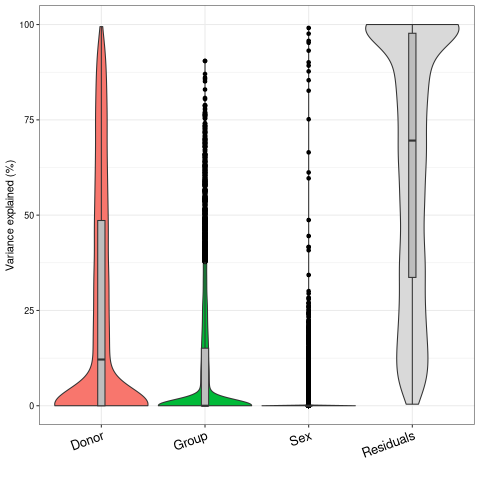

In [88]:
%%R

form <- ~ (1 | Group) + (1 | Sex) + (1 | Donor)
vp <- fitExtractVarPartModel(y2, form, treatments)

plotVarPart(sortCols(vp))

In addition: Warning message:
In .fitExtractVarPartModel(exprObj, formula, data, REML = REML,  :
  Model failed for 3 responses.
  See errors with attr(., 'errors')


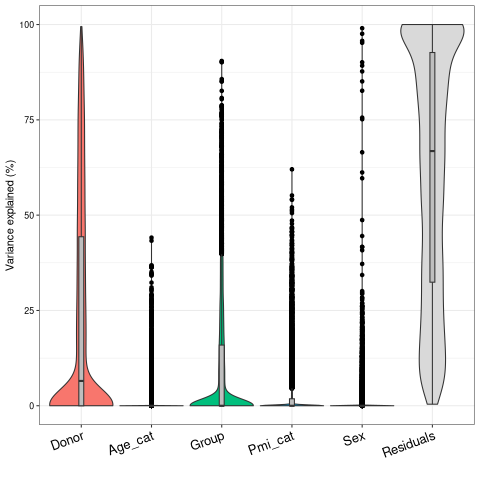

In [89]:
%%R

form <- ~ (1 | Group) + (1 | Sex) + (1 | Age_cat) + (1 | Pmi_cat) + (1 | Donor)
vp <- fitExtractVarPartModel(y2, form, treatments)

plotVarPart(sortCols(vp))

In [97]:
%%R
dim(tmp2)

[1] 10487     1


In [98]:
%%R
dim(fitmm)

[1] 10487     2


In [102]:
%%R
all(rownames(tmp2) == rownames(fitmm))

[1] TRUE


In [101]:
%%R
dim(vp)

[1] 10484     6


In [103]:
%%R
all(rownames(tmp2) == rownames(vp))

[1] FALSE


In addition: Warning message:
In rownames(tmp2) == rownames(vp) :
  longer object length is not a multiple of shorter object length


In [105]:
%%R
missing_rows <- setdiff(rownames(fitmm), rownames(vp))
print(missing_rows)

[1] "ZNF362"     "CLINT1"     "RASSF8-AS1"


In [108]:
%%R

# Define the rows to remove
rows_to_remove <- c("ZNF362", "CLINT1", "RASSF8-AS1")

# Remove them from tmp2
tmp2 <- tmp2[!(rownames(tmp2) %in% rows_to_remove), ]

# Remove them from fitmm
fitmm <- fitmm[!(rownames(fitmm) %in% rows_to_remove), ]

# Check dimensions again to confirm they match
dim(tmp2)

[1] 10484     1


In [107]:
%%R

dim(fitmm)

[1] 10484     2


Removing intercept from test coefficients


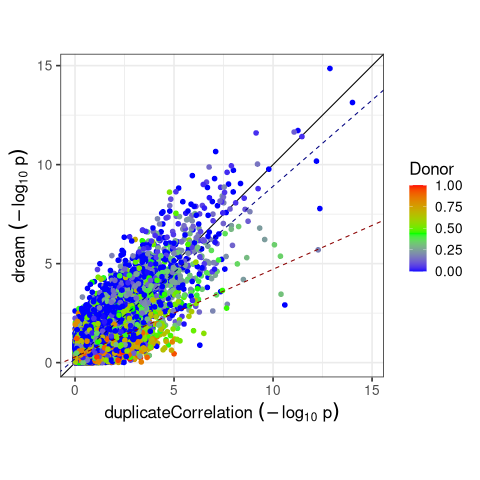

In [109]:
%%R

# Compare p-values and make plot
p1 <- topTable(tmp2, coef = "GroupAL - GroupWM", number = Inf, sort.by = "none")$P.Value
p2 <- topTable(fitmm, number = Inf, sort.by = "none")$P.Value

plotCompareP(p1, p2, vp$Donor, corfit2$consensus)

# Box plots of highly differentially expressed genes

In [157]:
%%R
library(reshape2)  # For transforming data from wide to long format
library(ggplot2)   # For plotting
library(edgeR)

In [158]:
%%R
class(x2)

[1] "DGEList"
attr(,"package")
[1] "edgeR"


In [159]:
%%R
#X2 is the norm lib sizes and trimmed
cpm <- edgeR::cpm(x2, log=FALSE, prior.counts=3)
lcpm <- edgeR::cpm(x2, log=TRUE, prior.count=3)

In [160]:
%%R
class(cpm)

[1] "matrix" "array" 


In [161]:
%%R

# Step 1: Combine Expression and Treatment Data
# Convert the E matrix into a dataframe
expr_df <- as.data.frame(cpm)
expr_df$gene <- rownames(cpm)  # Add gene names as a column
head(expr_df)

           Ind86-Sample2_WM Ind98-Sample2_WM Ind107-Sample1_WM
AL627309.1          4.63757         8.436521          8.301167
AL669831.5         69.56355        28.377387         29.647026
NOC2L              13.91271        23.008693         23.717621
AGRN               51.01327        36.046952         27.275264
C1orf159           55.65084        38.347821        116.216341
SDF4               41.73813        51.386080         30.832907
           Ind117-Sample1_WM Ind121-Sample1_WM Ind126-Sample1_WM
AL627309.1          7.279594          19.91254          7.074893
AL669831.5         30.798282           0.00000         25.320668
NOC2L              20.718844           0.00000         18.618138
AGRN               54.316970          19.91254         33.140286
C1orf159           70.556064          39.82507         48.779522
SDF4               39.757782          59.73761         49.524248
           Ind131-Sample1_WM Ind133-Sample1_WM Ind135-Sample1_WM
AL627309.1          4.285391          5

In [162]:
%%R
colnames(expr_df)

 [1] "Ind86-Sample2_WM"  "Ind98-Sample2_WM"  "Ind107-Sample1_WM"
 [4] "Ind117-Sample1_WM" "Ind121-Sample1_WM" "Ind126-Sample1_WM"
 [7] "Ind131-Sample1_WM" "Ind133-Sample1_WM" "Ind135-Sample1_WM"
[10] "Ind139-Sample1_WM" "Ind140-Sample1_WM" "Ind144-Sample1_WM"
[13] "Ind145-Sample1_WM" "Ind102-Sample1_AL" "Ind103-Sample1_AL"
[16] "Ind106-Sample1_AL" "Ind109-Sample1_AL" "Ind112-Sample1_AL"
[19] "Ind113-Sample2_AL" "Ind114-Sample1_AL" "Ind114-Sample2_AL"
[22] "Ind115-Sample1_AL" "Ind115-Sample2_AL" "Ind118-Sample1_AL"
[25] "Ind118-Sample2_AL" "Ind122-Sample1_AL" "Ind127-Sample1_AL"
[28] "Ind127-Sample3_AL" "Ind127-Sample4_AL" "Ind130-Sample1_AL"
[31] "Ind130-Sample2_AL" "Ind132-Sample1_AL" "gene"             


In [163]:
%%R
# Drop the "gene" column
expr_df <- expr_df[, !colnames(expr_df) %in% "gene"]

In [164]:
%%R

# Convert design matrix to a dataframe and add sample IDs as rownames
design_df <- as.data.frame(y2$design)
design_df$sample <- rownames(design_df)
head(design_df)

                  GroupAL GroupWM SexM Age_catover_70 Age_catunder_50
Ind86-Sample2_WM        0       1    1              1               0
Ind98-Sample2_WM        0       1    1              0               1
Ind107-Sample1_WM       0       1    1              0               1
Ind117-Sample1_WM       0       1    0              0               1
Ind121-Sample1_WM       0       1    0              0               1
Ind126-Sample1_WM       0       1    1              0               0
                  Pmi_catover_12H Pmi_catup_to_6H            sample
Ind86-Sample2_WM                1               0  Ind86-Sample2_WM
Ind98-Sample2_WM                1               0  Ind98-Sample2_WM
Ind107-Sample1_WM               1               0 Ind107-Sample1_WM
Ind117-Sample1_WM               1               0 Ind117-Sample1_WM
Ind121-Sample1_WM               1               0 Ind121-Sample1_WM
Ind126-Sample1_WM               0               0 Ind126-Sample1_WM


In [165]:
%%R

# Step 1: Rename the columns of expr_df to match the design information
colnames(expr_df) <- paste0("Sample", seq_len(ncol(expr_df) - 1))  # Adjust for gene column
expr_df$gene <- rownames(expr_df)

# Update design_df to have corresponding sample IDs
design_df$sample <- paste0("Sample", seq_len(nrow(design_df)))

# Step 2: Melt the expression data into a long format
expr_long <- melt(expr_df, id.vars = "gene", variable.name = "sample", value.name = "expression")

# Step 3: Merge expression data with treatment information
expr_treatment <- merge(expr_long, design_df, by = "sample")

In [166]:
%%R
head(expr_treatment)

   sample    gene expression GroupAL GroupWM SexM Age_catover_70
1 Sample1 ADPRHL2   32.46299       0       1    1              1
2 Sample1 TRAPPC3    9.27514       0       1    1              1
3 Sample1   FOXO6    9.27514       0       1    1              1
4 Sample1  HIVEP3   92.75140       0       1    1              1
5 Sample1   FOXJ3  111.30168       0       1    1              1
6 Sample1  CCDC30   83.47626       0       1    1              1
  Age_catunder_50 Pmi_catover_12H Pmi_catup_to_6H
1               0               1               0
2               0               1               0
3               0               1               0
4               0               1               0
5               0               1               0
6               0               1               0


In [167]:
%%R
# Subset data for the specified gene
gene_data <- subset(expr_treatment, gene == "TMEM132B")
gene_data$treatment <- ifelse(gene_data$GroupWM == 1, "WM", "AL")
head(gene_data)

        sample     gene expression GroupAL GroupWM SexM Age_catover_70
6399   Sample1 TMEM132B  106.66411       0       1    1              1
16885 Sample10 TMEM132B   41.21695       0       1    1              1
27372 Sample11 TMEM132B   34.18871       0       1    0              1
37860 Sample12 TMEM132B   45.82885       0       1    1              1
48346 Sample13 TMEM132B   41.86836       0       1    0              1
58833 Sample14 TMEM132B    0.00000       1       0    1              0
      Age_catunder_50 Pmi_catover_12H Pmi_catup_to_6H treatment
6399                0               1               0        WM
16885               0               0               1        WM
27372               0               0               0        WM
37860               0               0               1        WM
48346               0               0               1        WM
58833               0               0               0        AL


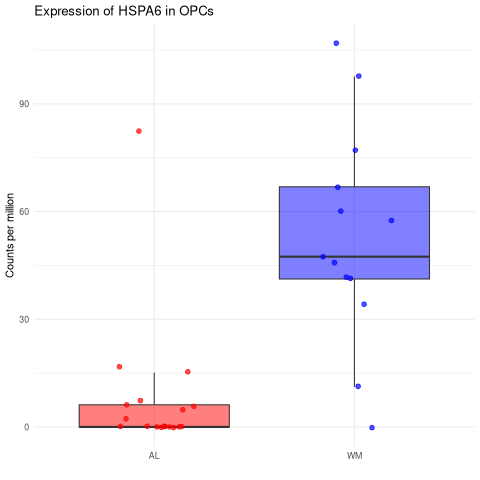

In [168]:
%%R
ggplot(gene_data, aes(x = treatment, y = expression, fill = treatment)) +
  geom_boxplot(alpha = 0.5, outlier.shape = NA) +  # Boxplots without outliers
  geom_jitter(width = 0.2, alpha = 0.7, size = 2, aes(color = treatment)) +  # Individual points
  scale_fill_manual(values = c("WM" = "blue", "AL" = "red")) +  # Custom colors for boxes
  scale_color_manual(values = c("WM" = "blue", "AL" = "red")) +  # Custom colors for points
  labs(
    title = "Expression of HSPA6 in OPCs",
    x = "",
    y = "Counts per million"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

In [169]:
%%R
# Subset data for the specified gene
gene_data <- subset(expr_treatment, gene == "GBP2")
gene_data$treatment <- ifelse(gene_data$GroupWM == 1, "WM", "AL")
head(gene_data)

        sample gene expression GroupAL GroupWM SexM Age_catover_70
9649   Sample1 GBP2   0.000000       0       1    1              1
20136 Sample10 GBP2   0.000000       0       1    1              1
24061 Sample11 GBP2   0.000000       0       1    0              1
31510 Sample12 GBP2   6.623701       0       1    1              1
51597 Sample13 GBP2   0.000000       0       1    0              1
52606 Sample14 GBP2  50.947305       1       0    1              0
      Age_catunder_50 Pmi_catover_12H Pmi_catup_to_6H treatment
9649                0               1               0        WM
20136               0               0               1        WM
24061               0               0               0        WM
31510               0               0               1        WM
51597               0               0               1        WM
52606               0               0               0        AL


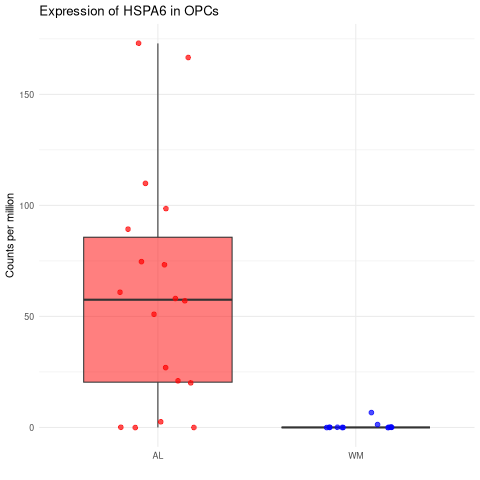

In [170]:
%%R
ggplot(gene_data, aes(x = treatment, y = expression, fill = treatment)) +
  geom_boxplot(alpha = 0.5, outlier.shape = NA) +  # Boxplots without outliers
  geom_jitter(width = 0.2, alpha = 0.7, size = 2, aes(color = treatment)) +  # Individual points
  scale_fill_manual(values = c("WM" = "blue", "AL" = "red")) +  # Custom colors for boxes
  scale_color_manual(values = c("WM" = "blue", "AL" = "red")) +  # Custom colors for points
  labs(
    title = "Expression of HSPA6 in OPCs",
    x = "",
    y = "Counts per million"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

# Try to plot some genes to see if you belive results

In [171]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm, colors
#from gprofiler import gprofiler

In [172]:
from matplotlib import rcParams
from matplotlib import cm, colors

# Create a custom color map using 'PuRd' color map
colors2 = plt.cm.PuRd(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7, 0.8, 20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [173]:
#Define a nice colour map for gene expression
colors2 = plt.cm.plasma(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap2 = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [174]:
plt.rcParams['figure.figsize']=(5,5) #rescale figures
sc.settings.verbosity = 3
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=300,transparent=True, fontsize=12) #color_map=mymap2)
sc.settings.figdir = '/afs/crc.nd.edu/user/e/eaboelno/sysVI_analysis/Human_scVI_single/figures_OL/'
sc.logging.print_header()

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


In [175]:
adata= sc.read_h5ad('/scratch365/eaboelno/BACKUP_h5ad_IMPORTANT/scVI_mdata_OL_NEW.h5ad')
adata

AnnData object with n_obs × n_vars = 200872 × 27766
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 's_score', 'g2m_score', 'phase', 'cell_cycle_diff', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'pct_counts_ribo', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'n_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'S_score', 'G2M_score', 'Cycling cells', 'Cycling_cells', 'Microglia', 'DAM', 'Macrophages', 'BAM', 'Monocytes', 'DC

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_lesion_type']`


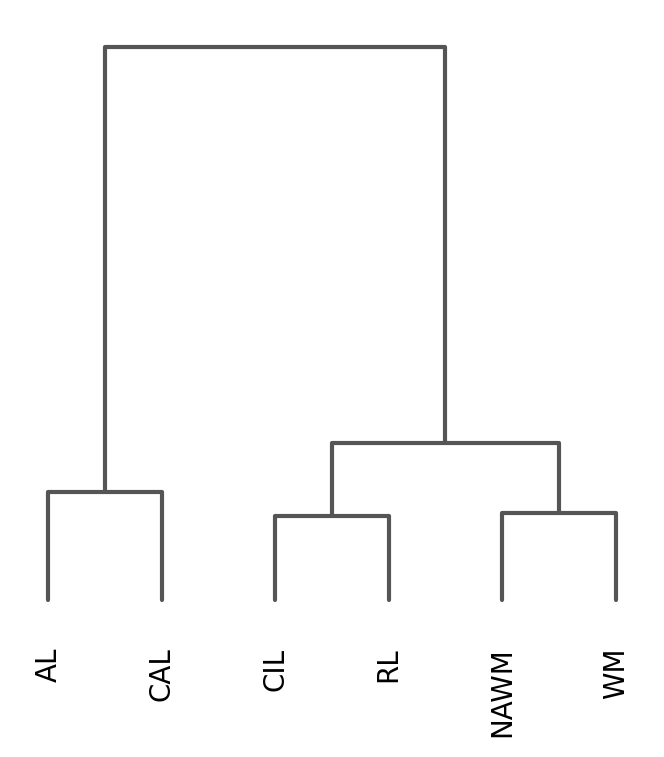

<Axes: >

In [176]:
sc.tl.dendrogram(adata, 'lesion_type')
sc.pl.dendrogram(adata, 'lesion_type')

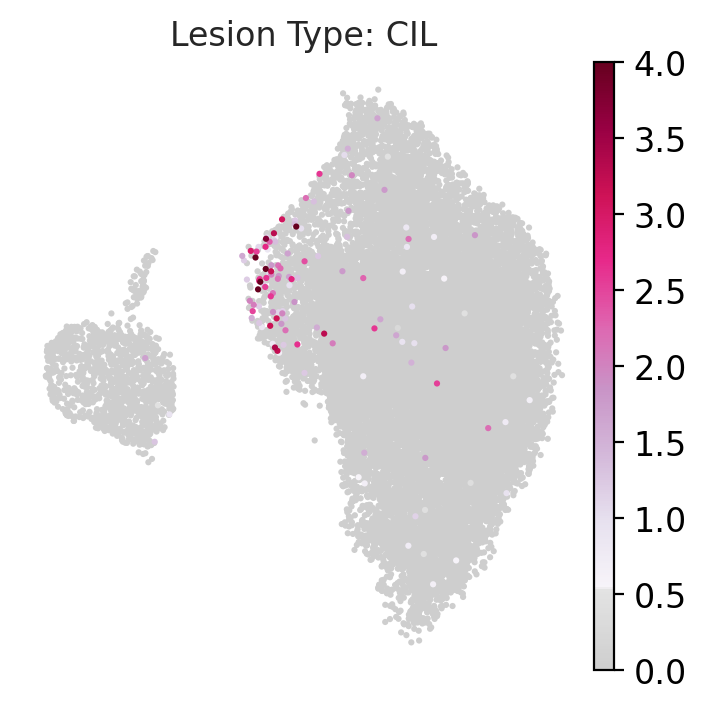

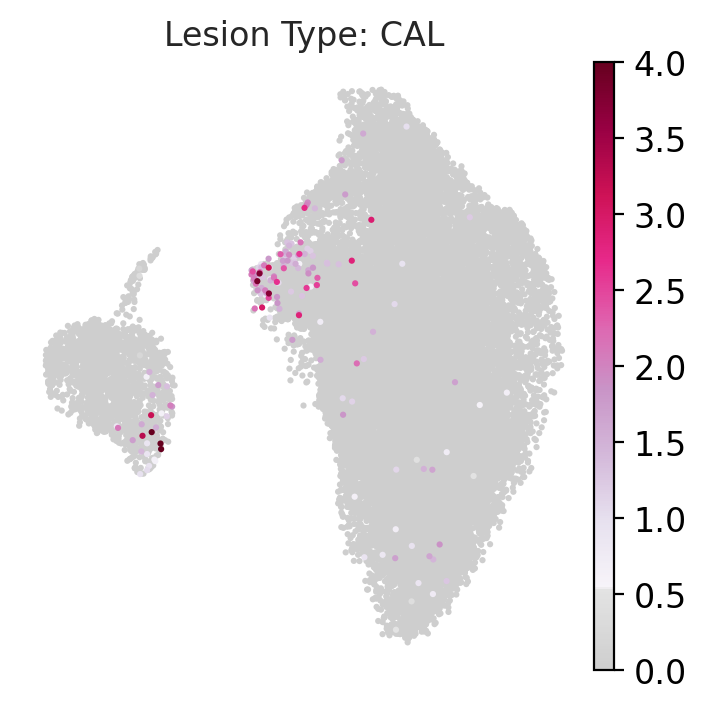

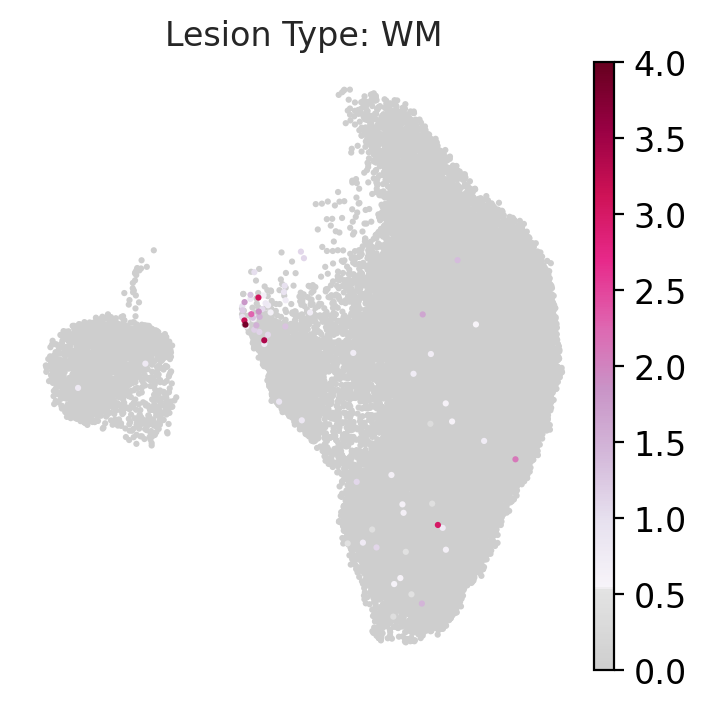

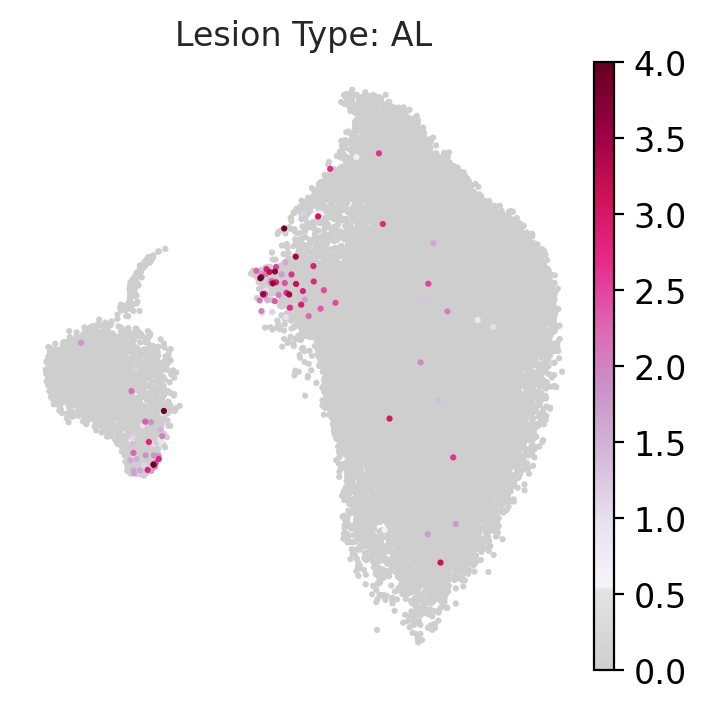

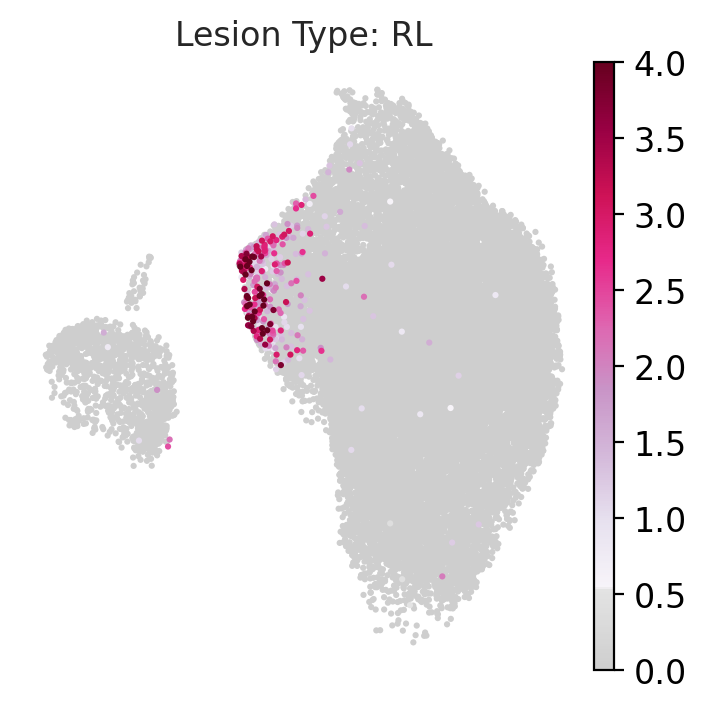

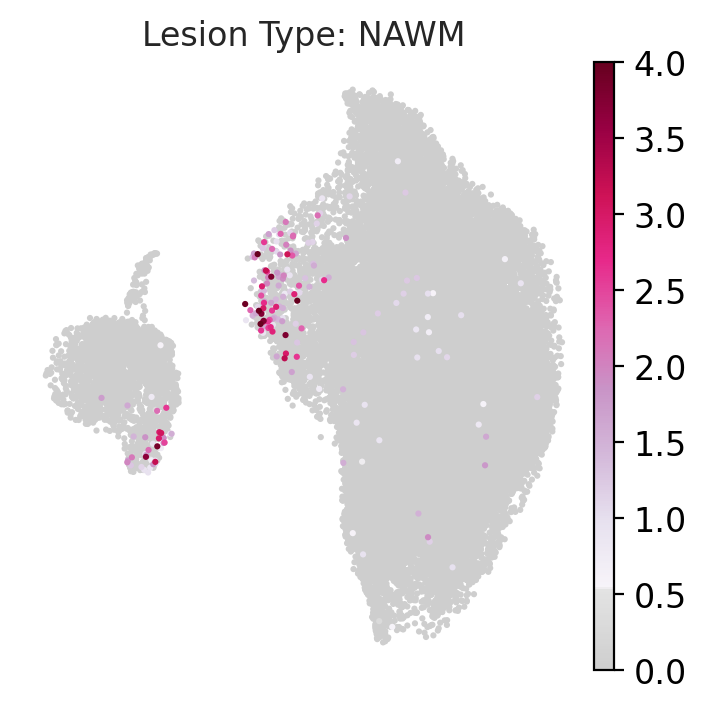

In [196]:
# Specify the gene name you want to include in the filename
gene_name = 'SERPINE1'  # You can change this to any gene name you wish to use

# Loop through each unique value in 'lesion_status'
for lesion_type in set(adata.obs['lesion_type']):
    # Subset the data to only include the current lesion type
    adata_subset = adata[adata.obs['lesion_type'] == lesion_type]
    
    # Generate the UMAP plot for the current subset
    sc.pl.embedding(
        adata_subset, 
        basis='X_umap', 
        color=gene_name,  # Use the gene name
        layer='log1p_norm',
        color_map=mymap, 
        legend_fontweight='normal', 
        s=20, 
        frameon=False,
        vmax=4,
        title=f"Lesion Type: {lesion_type}",
        #save=f'_{gene_name}_lesion_status_{lesion_type}.png'  # Save with gene name and lesion type
    )
    
    # Show the plot
    plt.show()

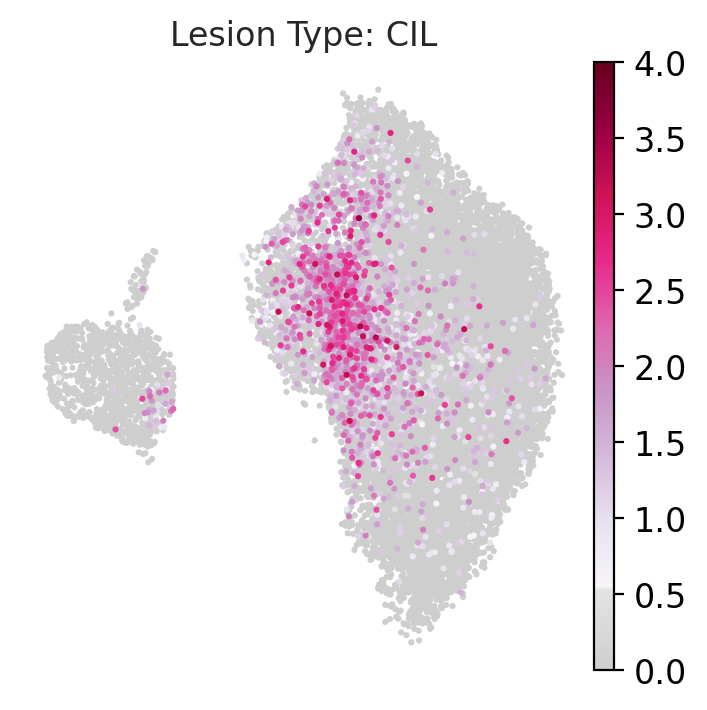

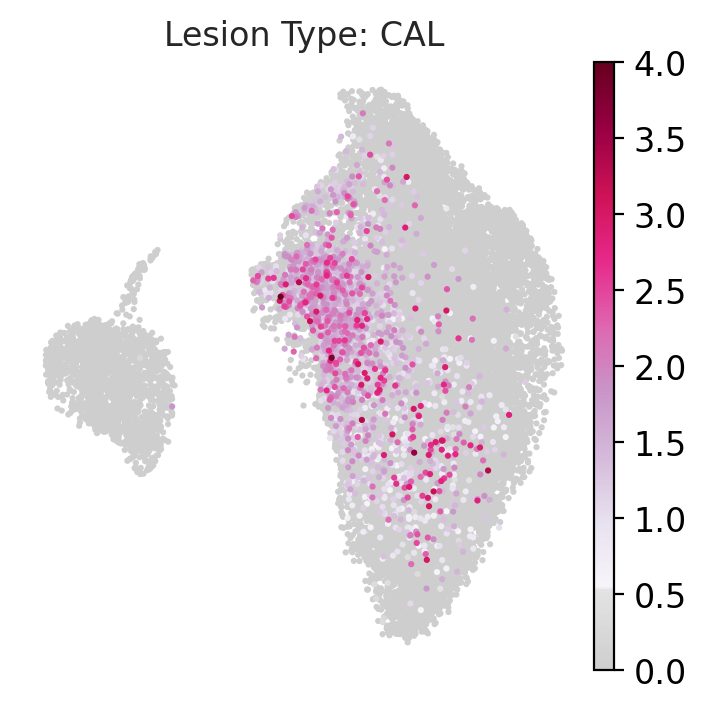

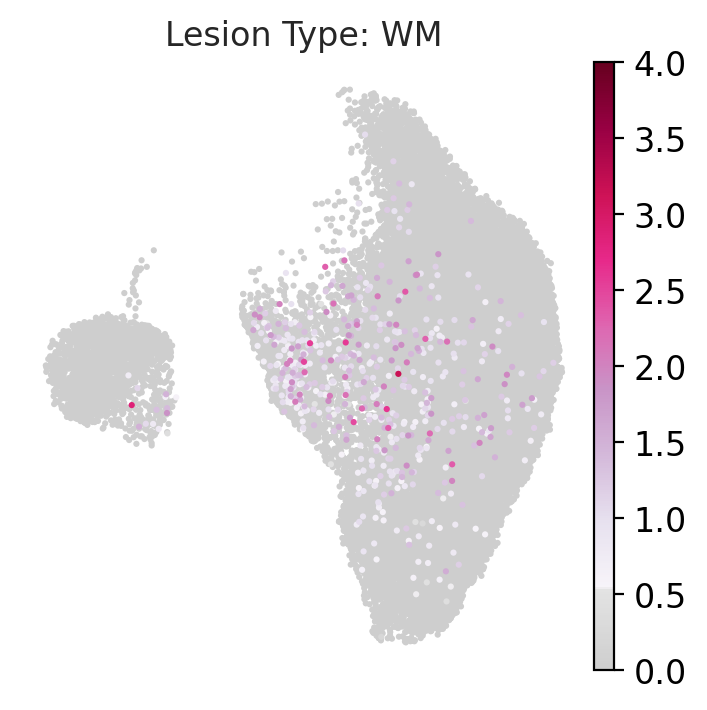

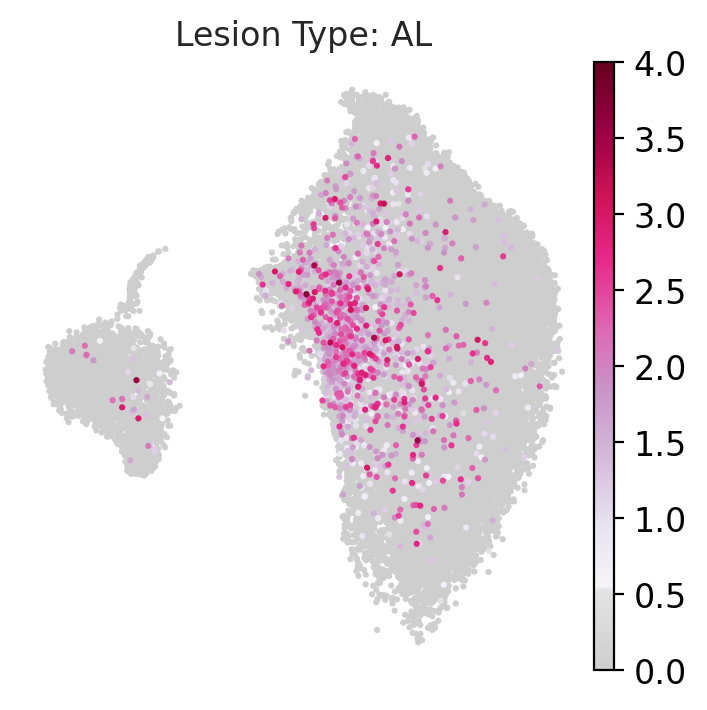

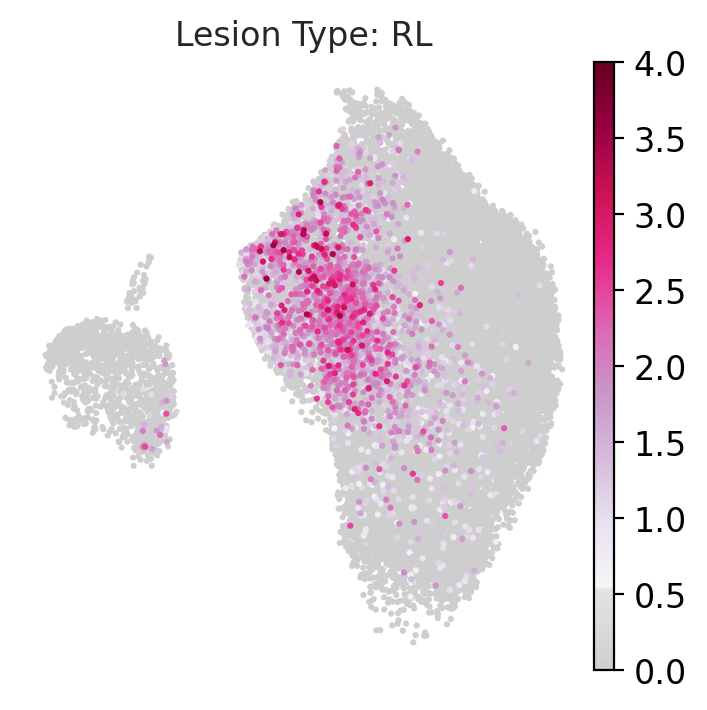

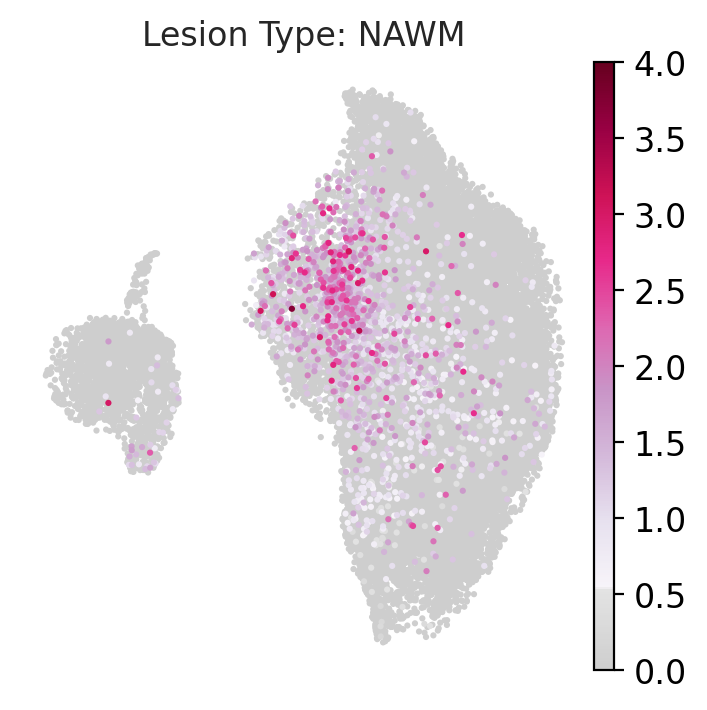

In [177]:
# Specify the gene name you want to include in the filename
gene_name = 'GBP2'  # You can change this to any gene name you wish to use

# Loop through each unique value in 'lesion_status'
for lesion_type in set(adata.obs['lesion_type']):
    # Subset the data to only include the current lesion type
    adata_subset = adata[adata.obs['lesion_type'] == lesion_type]
    
    # Generate the UMAP plot for the current subset
    sc.pl.embedding(
        adata_subset, 
        basis='X_umap', 
        color=gene_name,  # Use the gene name
        layer='log1p_norm',
        color_map=mymap, 
        legend_fontweight='normal', 
        s=20, 
        frameon=False,
        vmax=4,
        title=f"Lesion Type: {lesion_type}",
        #save=f'_{gene_name}_lesion_status_{lesion_type}.png'  # Save with gene name and lesion type
    )
    
    # Show the plot
    plt.show()

# Do results overlap with LR pairs?

In [180]:
import liana as li

In [181]:
lr_pairs = li.resource.select_resource('consensus')
lr_pairs.head()

,ligand,receptor
0,LGALS9,PTPRC
1,LGALS9,MET
2,LGALS9,CD44
3,LGALS9,LRP1
4,LGALS9,CD47


In [182]:
%R -o tt_dream

In [183]:
# Display the first few rows
tt_dream.head()

,gene,gene.1,logFC,AveExpr,t,P.Value,adj.P.Val,B
FCHSD2,FCHSD2,FCHSD2,1.581572,8.619551,13.883072,1.396070e-15,1.464058e-11,25.108251
OPALIN,OPALIN,OPALIN,3.605888,6.701410,12.501880,7.294486e-14,3.824864e-10,13.909813
KCNAB1,KCNAB1,KCNAB1,3.377023,5.981777,10.714100,1.899705e-12,5.260495e-09,18.037926
INPP5F,INPP5F,INPP5F,-2.975575,6.433039,-11.694984,2.258445e-12,5.260495e-09,9.405133
ST8SIA5,ST8SIA5,ST8SIA5,-3.377412,5.242225,-10.601996,2.508103e-12,5.260495e-09,18.047799


In [184]:
tt_dream.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
tt_dream.rename(columns={'P.Value': 'Pvalue'}, inplace=True)

In [185]:
# Move row names to a column called 'gene'
tt_dream['gene'] = tt_dream.index

# Reset the index so the gene names become part of the dataframe
tt_dream.reset_index(drop=True, inplace=True)

# Display the updated dataframe
tt_dream.head()

,gene,gene.1,logFC,AveExpr,t,Pvalue,Padj,B
0,FCHSD2,FCHSD2,1.581572,8.619551,13.883072,1.396070e-15,1.464058e-11,25.108251
1,OPALIN,OPALIN,3.605888,6.701410,12.501880,7.294486e-14,3.824864e-10,13.909813
2,KCNAB1,KCNAB1,3.377023,5.981777,10.714100,1.899705e-12,5.260495e-09,18.037926
3,INPP5F,INPP5F,-2.975575,6.433039,-11.694984,2.258445e-12,5.260495e-09,9.405133
4,ST8SIA5,ST8SIA5,-3.377412,5.242225,-10.601996,2.508103e-12,5.260495e-09,18.047799


In [186]:
sigs = tt_dream[(tt_dream.Padj < 0.05) & (abs(tt_dream.logFC) >= 1)]
sigs.shape

(872, 8)

In [187]:
lr_pairs.shape

(4624, 2)

In [188]:
sigs.head()

,gene,gene.1,logFC,AveExpr,t,Pvalue,Padj,B
0,FCHSD2,FCHSD2,1.581572,8.619551,13.883072,1.396070e-15,1.464058e-11,25.108251
1,OPALIN,OPALIN,3.605888,6.701410,12.501880,7.294486e-14,3.824864e-10,13.909813
2,KCNAB1,KCNAB1,3.377023,5.981777,10.714100,1.899705e-12,5.260495e-09,18.037926
3,INPP5F,INPP5F,-2.975575,6.433039,-11.694984,2.258445e-12,5.260495e-09,9.405133
4,ST8SIA5,ST8SIA5,-3.377412,5.242225,-10.601996,2.508103e-12,5.260495e-09,18.047799


In [189]:
ligands = lr_pairs['ligand'].unique()
receptors = lr_pairs['receptor'].unique()

# Combining both ligands and receptors and keeping only unique values
unique_genes = set(ligands).union(set(receptors))

# Checking for overlap with 'sigs' dataframe on the 'gene' column
overlap_genes = sigs[sigs['gene'].isin(unique_genes)]
overlap_genes

,gene,gene.1,logFC,AveExpr,t,Pvalue,Padj,B
10,NGFR,NGFR,-3.293938,3.914069,-10.006755,1.322945e-10,1.261247e-07,6.967029
16,IL6R,IL6R,-3.711189,3.409864,-8.844252,7.625443e-10,4.704002e-07,7.614790
18,SEMA6D,SEMA6D,2.207062,6.269713,8.589050,9.576516e-10,5.261274e-07,8.464111
35,LGI4,LGI4,-2.055770,4.720706,-8.075043,6.958598e-09,2.027078e-06,5.954403
38,SLITRK1,SLITRK1,1.600166,4.044730,7.798235,7.668421e-09,2.062019e-06,10.163592
...,...,...,...,...,...,...,...,...
1888,CIRBP,CIRBP,1.055943,7.294969,2.987794,6.949748e-03,3.858232e-02,-2.644205
1925,PTPN6,PTPN6,-1.739079,1.091781,-2.902050,7.526593e-03,4.098203e-02,-2.801450
1962,ANGPT2,ANGPT2,-1.184769,4.022854,-2.849536,8.127860e-03,4.341540e-02,-2.850306
2046,TNFRSF21,TNFRSF21,-1.284293,2.827445,-2.792089,9.081810e-03,4.652709e-02,-2.969192


In [190]:
# Checking the direction of logFC for the overlapping genes
overlap_genes_direction = overlap_genes[['gene', 'logFC']].copy()

# Determine the direction of logFC
overlap_genes_direction['logFC_direction'] = overlap_genes_direction['logFC'].apply(lambda x: 'positive' if x > 0 else 'negative')

# Displaying the results
overlap_genes_direction

,gene,logFC,logFC_direction
10,NGFR,-3.293938,negative
16,IL6R,-3.711189,negative
18,SEMA6D,2.207062,positive
35,LGI4,-2.055770,negative
38,SLITRK1,1.600166,positive
...,...,...,...
1888,CIRBP,1.055943,positive
1925,PTPN6,-1.739079,negative
1962,ANGPT2,-1.184769,negative
2046,TNFRSF21,-1.284293,negative


In [191]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 27


,ligand,receptor,logFC_ligand,logFC_receptor
0,CDH1,IGF1R,2.344820,-1.349702
1,CDH1,PTPRM,2.344820,-2.148995
2,CNTN1,NRCAM,2.338705,-2.850944
6,LAMA2,CD44,1.841942,-3.753549
7,LAMA2,ITGA1,1.841942,-1.057596
14,PTN,PTPRB,1.703565,-2.260451
8,COL9A2,CD44,1.246425,-3.753549
21,OMG,NGFR,1.184468,-3.293938
23,NRG2,MOG,-1.090567,1.076056
24,NRG2,NRP2,-1.090567,-2.514363


In [193]:
sigs_up = tt_dream[(tt_dream.Padj < 0.05) & (tt_dream.logFC <= -1)]
sigs_up.shape

(598, 8)

In [195]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs_up['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=True)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 16


,ligand,receptor,logFC_ligand,logFC_receptor
10,SERPINE1,ITGB5,-5.038207,-1.733308
14,CLCF1,SORL1,-3.852535,-1.630867
9,VIM,CD44,-3.639251,-3.753549
6,APOE,SORL1,-3.587914,-1.630867
7,NPY,FAP,-2.650271,-2.540140
0,LAMC1,CD44,-2.609711,-3.753549
1,LAMC1,ITGA1,-2.609711,-1.057596
15,MFGE8,ITGB5,-2.482130,-1.733308
11,LPL,CD44,-2.352090,-3.753549
8,COL18A1,ITGA5,-2.316550,-3.614384


In [ ]:
#sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']].to_csv('./files/LR_pairs_OPC_up_AL_CAL_updated.csv', sep='\t', index=False)

# Check overlap voom-wqw and dream

In [113]:
OPC_orig = pd.read_csv('./files/MOL_GvC_WM_v_AL_vwqw_blocked.csv', index_col=None)
OPC_orig.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
OPC_orig.rename(columns={'P.Value': 'Pvalue'}, inplace=True)
OPC_orig.shape

(10487, 7)

In [114]:
OPC_orig.head

<bound method NDFrame.head of            gene     logFC    AveExpr          t        Pvalue          Padj  \
0          ANK3 -1.592753  10.551017 -14.361085  1.387716e-15  1.015878e-11   
1        PLPPR1 -2.080521   7.336685 -14.191137  1.937405e-15  1.015878e-11   
2        OPALIN -4.213407   6.701409 -13.702916  5.136909e-15  1.795692e-11   
3        FCHSD2 -1.625124   8.619550 -13.086875  1.822714e-14  3.959859e-11   
4        INPP5F  3.177969   6.433038  13.070044  1.887984e-14  3.959859e-11   
...         ...       ...        ...        ...           ...           ...   
10482  MTRNR2L8 -0.003219   6.172923  -0.002415  9.980878e-01  9.984687e-01   
10483   CCDC149 -0.000287   5.603846  -0.001532  9.987869e-01  9.990727e-01   
10484    UTP14A  0.000238   3.869954   0.000872  9.993097e-01  9.995003e-01   
10485    ZNF329  0.000158   3.874483   0.000664  9.994742e-01  9.995695e-01   
10486     GANAB -0.000025   5.054611  -0.000130  9.998973e-01  9.998973e-01   

               B  
0 

In [136]:
OPC_new = pd.read_csv('./files/MOL_GvC_WM_v_AL_dream.csv', index_col=None)
OPC_new.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
OPC_new.rename(columns={'P.Value': 'Pvalue'}, inplace=True)
OPC_new.shape

(10487, 8)

In [137]:
OPC_new.head

<bound method NDFrame.head of              gene      gene.1     logFC   AveExpr          t        Pvalue  \
0          FCHSD2      FCHSD2  1.581572  8.619551  13.883072  1.396070e-15   
1          OPALIN      OPALIN  3.605888  6.701410  12.501880  7.294486e-14   
2          KCNAB1      KCNAB1  3.377023  5.981777  10.714100  1.899705e-12   
3          INPP5F      INPP5F -2.975575  6.433039 -11.694984  2.258445e-12   
4         ST8SIA5     ST8SIA5 -3.377412  5.242225 -10.601996  2.508103e-12   
...           ...         ...       ...       ...        ...           ...   
10482       PQLC3       PQLC3  0.000509  3.479509   0.001607  9.987300e-01   
10483       SERP1       SERP1  0.000235  5.622406   0.001446  9.988544e-01   
10484       EDEM2       EDEM2  0.000104  3.720659   0.000378  9.997010e-01   
10485      AGPAT3      AGPAT3 -0.000030  6.193589  -0.000215  9.998304e-01   
10486  AP000462.1  AP000462.1  0.000046  4.285790   0.000091  9.999282e-01   

               Padj          B  


In [150]:
# Load and process OPC_orig for upregulated and downregulated genes
OPC_orig_up = OPC_orig[(OPC_orig.logFC >= 0.7)]
OPC_orig_down = OPC_orig[(OPC_orig.logFC <= -0.7)]
print(OPC_orig_up.shape)
print(OPC_orig_down.shape)

(1523, 7)
(838, 7)


In [178]:
# Load and process OPC_orig for upregulated and downregulated genes
OPC_new_down = OPC_new[(OPC_new.Padj < 0.05) & (OPC_new.logFC >= 0.7)]
OPC_new_up = OPC_new[(OPC_new.Padj < 0.05) & (OPC_new.logFC <= -0.7)]
print(OPC_new_up.shape)
print(OPC_new_down.shape)

(900, 8)
(501, 8)


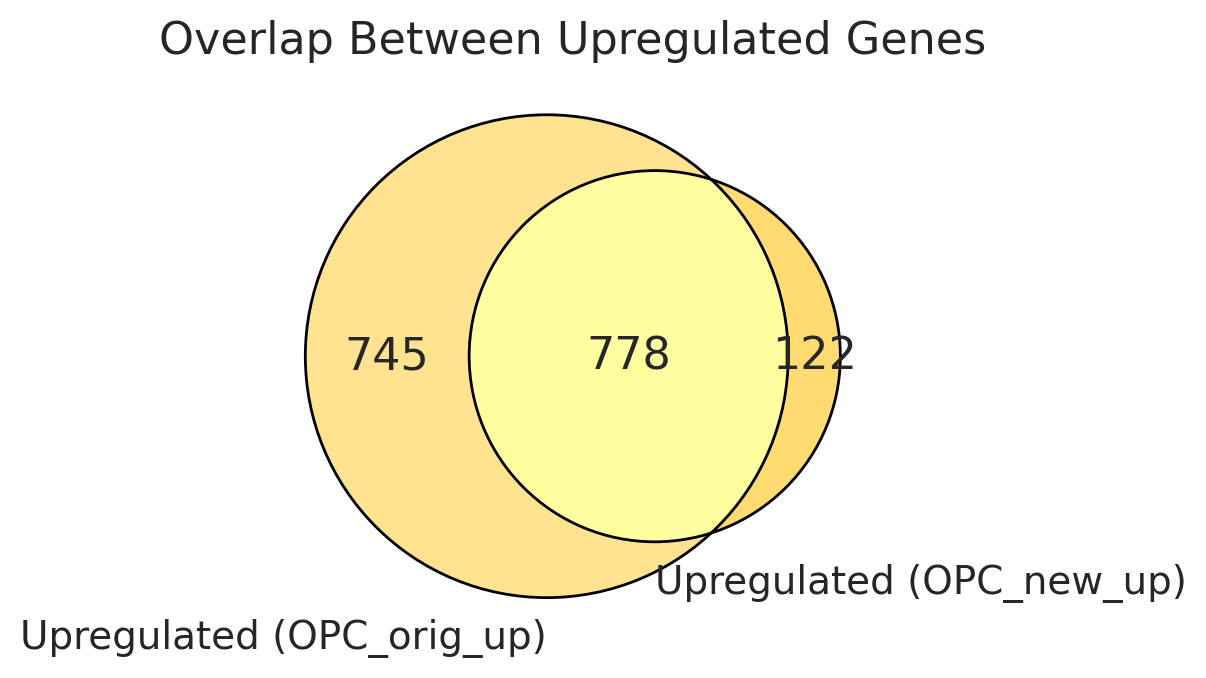

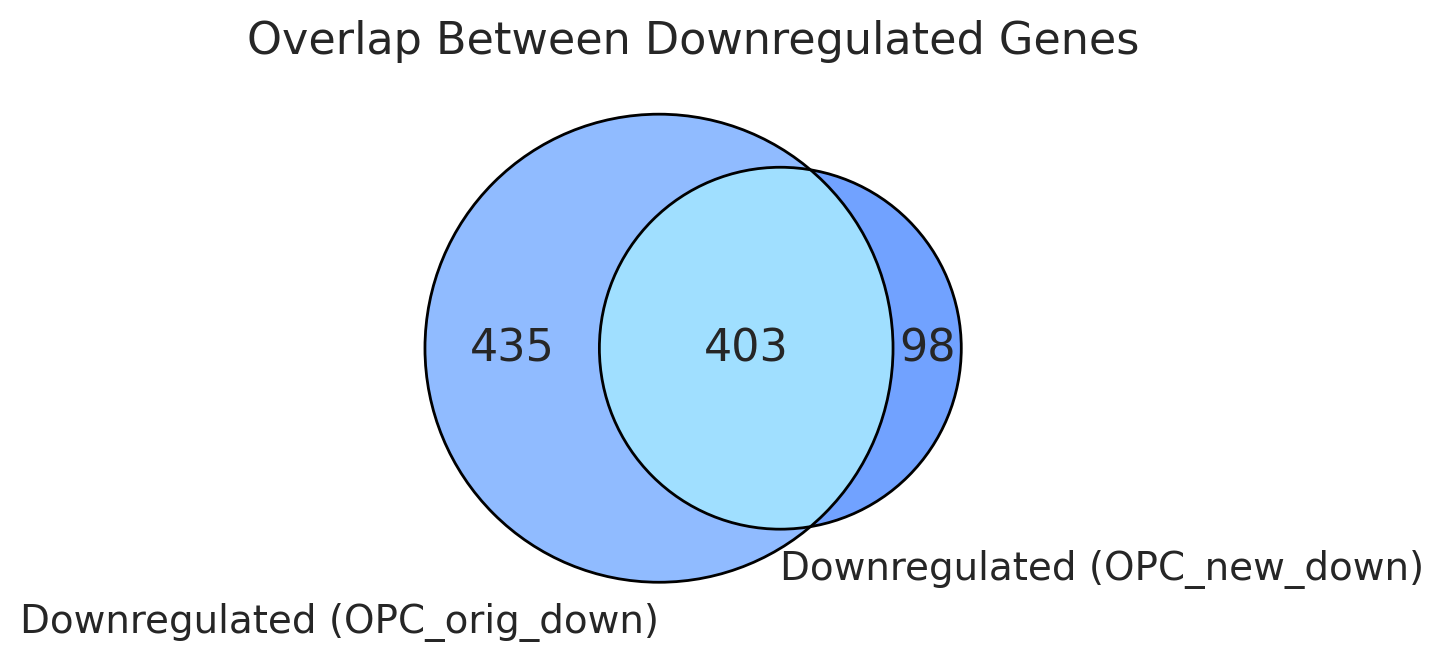

In [179]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles

# Assuming you have the original and new upregulated/downregulated dataframes
# Extract sets of gene symbols for comparison
set_OPC_orig_up = set(OPC_orig_up['gene'])
set_OPC_orig_down = set(OPC_orig_down['gene'])
set_OPC_new_up = set(OPC_new_up['gene'])
set_OPC_new_down = set(OPC_new_down['gene'])

# Calculate lengths and overlap for upregulated genes
length_orig_up_only = len(set_OPC_orig_up - set_OPC_new_up)
length_new_up_only = len(set_OPC_new_up - set_OPC_orig_up)
common_up = set_OPC_orig_up & set_OPC_new_up
length_common_up = len(common_up)

# Plot Venn diagram for upregulated genes
venn_up = venn2(subsets=(length_orig_up_only, length_new_up_only, length_common_up),
                set_labels=('Upregulated (OPC_orig_up)', 'Upregulated (OPC_new_up)'),
                set_colors=('#ffdd75', '#ffd34e'),
                alpha=0.8)

venn2_circles(subsets=(length_orig_up_only, length_new_up_only, length_common_up), linewidth=1)

# Customize font sizes
for subset in venn_up.subset_labels:
    if subset:
        subset.set_fontsize(16)
for text in venn_up.set_labels:
    text.set_fontsize(14)

# Add a title and show the plot
plt.title('Overlap Between Upregulated Genes', fontsize=16)
plt.show()

# Calculate lengths and overlap for downregulated genes
length_orig_down_only = len(set_OPC_orig_down - set_OPC_new_down)
length_new_down_only = len(set_OPC_new_down - set_OPC_orig_down)
common_down = set_OPC_orig_down & set_OPC_new_down
length_common_down = len(common_down)

# Plot Venn diagram for downregulated genes
venn_down = venn2(subsets=(length_orig_down_only, length_new_down_only, length_common_down),
                  set_labels=('Downregulated (OPC_orig_down)', 'Downregulated (OPC_new_down)'),
                  set_colors=('#75aaff', '#4e8bff'),
                  alpha=0.8)

venn2_circles(subsets=(length_orig_down_only, length_new_down_only, length_common_down), linewidth=1)

# Customize font sizes
for subset in venn_down.subset_labels:
    if subset:
        subset.set_fontsize(16)
for text in venn_down.set_labels:
    text.set_fontsize(14)

# Add a title and show the plot
plt.title('Overlap Between Downregulated Genes', fontsize=16)
plt.show()

In [ ]:
print(length_common_up)
print(common_up)

In [ ]:
print(length_common_down)
print(common_down)